------------------------------------------------------------------------------
Проект: Анализ доли безналичных трат в начисленной зарплате

Автор: Олег Адамович

Заказчик: Хакатон «Муниципальный код» (Сбер)

------------------------------------------------------------------------------
Цель проекта:
Выявить закономерности и аномалии в структуре безналичных платежей
на уровне муниципалитетов России, определить факторы, влияющие на их долю
(урбанизация, доходы, миграция, рыночная связанность и др.),
и классифицировать муниципалитеты по паттернам потребительского поведения.

------------------------------------------------------------------------------
Основные этапы:
1. Загрузка и предобработка данных
2. Стандартизация признаков
3. Кластеризация муниципалитетов по структуре потребления
4. Построение регрессионной модели факторов безналичных трат
5. Визуализация и интерпретация результатов
------------------------------------------------------------------------------

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import re
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import statsmodels.api as sm


In [2]:
# Убираем ограничение на количество выводимых строк
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Посмотрим на доступность к рынкам товаров

In [3]:
market = pd.read_parquet('1_market_access.parquet', engine="fastparquet")

In [4]:
market.head(3)

,territory_id,market_access
0,1,309.6
1,2,322.8
2,3,315.2


In [5]:
market['territory_id'].nunique()

2571

In [6]:
market['territory_id'] = market['territory_id'].astype(int)

## Данные о населении

In [7]:
population = pd.read_parquet('2_bdmo_population.parquet', engine="fastparquet")

In [8]:
population.head()

,territory_id,year,period,age,gender,value
0,1402,2023,год,0,Женщины,288.0
1,1402,2023,год,0,Мужчины,301.0
2,1402,2023,год,1,Женщины,277.0
3,1402,2023,год,1,Мужчины,316.0
4,1402,2023,год,10,Женщины,414.0


In [9]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700215 entries, 0 to 700214
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   territory_id  700215 non-null  int64  
 1   year          700215 non-null  int64  
 2   period        700215 non-null  object 
 3   age           700215 non-null  object 
 4   gender        700215 non-null  object 
 5   value         698508 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 32.1+ MB


In [10]:
population['year'].unique()

array([2023, 2024])

In [11]:
population['territory_id'].nunique()

2449

In [12]:
population['age'].value_counts()

age
Всего    9634
9        9604
1        9600
3        9600
6        9596
0        9596
7        9596
8        9596
50       9594
5        9592
2        9592
4        9592
17       9592
55       9590
19       9588
34       9586
52       9586
54       9586
47       9586
53       9586
67       9586
51       9586
30       9586
10       9584
15       9584
11       9584
56       9582
58       9582
42       9582
64       9582
57       9582
59       9582
39       9582
16       9580
13       9580
14       9580
12       9580
18       9580
22       9580
32       9578
26       9578
25       9578
31       9578
66       9578
33       9578
27       9578
46       9578
48       9578
49       9578
45       9578
28       9578
29       9578
68       9578
69       9578
65       9578
20       9577
23       9574
24       9574
21       9574
40       9574
41       9574
44       9574
43       9574
35       9574
37       9574
36       9574
38       9574
60       9574
70+      9574
63       9574
62       9574
61

In [13]:
#переименуем колонку для будущего удобства
population = population.rename(columns={'value': 'population_value'})

In [14]:
population_all = population[population['age'] == 'Всего']

Посмотрим на значения для одного случайного муниципалитета

In [15]:
print(population_all[population_all['territory_id'] == random.choice(population_all['territory_id'].unique())])

        territory_id  year period    age   gender  population_value
467020           421  2023    год  Всего  Женщины           24340.0
467021           421  2023    год  Всего  Мужчины           19698.0
467166           421  2024    год  Всего  Женщины           24069.0
467167           421  2024    год  Всего  Мужчины           19488.0


In [16]:
population_all['territory_id'].nunique()

2447

#### Потерялись два territory_id

In [17]:
# Находим territory_id, которые есть в population, но отсутствуют в population_all
lost_territories = set(population['territory_id'].unique()) - set(population_all['territory_id'].unique())

print(f"Потерянные territory_id: {lost_territories}")

# Выводим все строки из population с этими territory_id
lost_data = population[population['territory_id'].isin(lost_territories)]
print(f"\nВсе строки с потерянными territory_id ({len(lost_data)} строк):")
print(lost_data)


Потерянные territory_id: {np.int64(1045), np.int64(1046)}

Все строки с потерянными territory_id (8 строк):
        territory_id  year period age   gender  population_value
610577          1045  2023    год  17  Женщины               NaN
610578          1045  2023    год  17  Мужчины               NaN
610579          1045  2024    год  17  Женщины               NaN
610580          1045  2024    год  17  Мужчины               NaN
610581          1046  2023    год  17  Женщины               NaN
610582          1046  2023    год  17  Мужчины               NaN
610583          1046  2024    год  17  Женщины               NaN
610584          1046  2024    год  17  Мужчины               NaN


Данные для двух муниципалитетов неполны.

Посчитаем мужчин и женщин вместе.

In [18]:
# Группируем по territory_id, year и period, суммируем value
population_total = population_all.groupby(['territory_id', 'year'])['population_value'].sum().reset_index()

# Переименовываем колонку для ясности
population_total = population_total.rename(columns={'population_value': 'total_population'})

# Выводим результат
print(population_total.head())


   territory_id  year  total_population
0             1  2023          163766.0
1             1  2024          161898.0
2             2  2023           15614.0
3             2  2024           15661.0
4             3  2023           31933.0


In [19]:
population_total.head()

,territory_id,year,total_population
0,1,2023,163766.0
1,1,2024,161898.0
2,2,2023,15614.0
3,2,2024,15661.0
4,3,2023,31933.0


In [20]:
population_total[['territory_id', 'year']] = population_total[['territory_id', 'year']].astype(int)

## Посмотрим на данные о городском и сельском населении. Датасеты взяты с сайта Если быть точным.

In [21]:
urban_population = pd.read_parquet('численность городского населения в 2024 году.parquet', engine="fastparquet")

In [22]:
urban_population.head(2)

,indicator_section_code,indicator_section,indicator_code,indicator_name,grup_2,vozr,region_id,region_name,mun_level,mun_district,municipality,oktmo,mun_type,mun_type_oktmo,oktmo_stable,oktmo_history,oktmo_year_from,oktmo_year_to,year,indicator_value,indicator_unit,indicator_period,comment
0,31,Население,Y48112015,Численность городского населения по полу и воз...,Мужчины,40‒44,01,Алтайский край,Муниципальное образование верхнего уровня,Муниципальный округ город Славгород,Муниципальный округ город Славгород,01539000,Муниципальный округ,Муниципальный округ,01539000,"Изменен тип и название, Объединение",2023,2025,2024,1002.0,Человек,На 1 января,CD
1,31,Население,Y48112015,Численность городского населения по полу и воз...,Мужчины,1‒6,01,Алтайский край,Муниципальное образование верхнего уровня,Муниципальный округ город Славгород,Муниципальный округ город Славгород,01539000,Муниципальный округ,Муниципальный округ,01539000,"Изменен тип и название, Объединение",2023,2025,2024,696.0,Человек,На 1 января,CD


In [23]:
rural_population = pd.read_csv('сельское население в 2024 ЕБТ.csv', sep=None, engine='python')

In [24]:
rural_population.head(3)

,indicator_section_code,indicator_section,indicator_code,indicator_name,grup_2,vozr,region_id,region_name,mun_level,mun_district,municipality,oktmo,mun_type,mun_type_oktmo,oktmo_stable,oktmo_history,oktmo_year_from,oktmo_year_to,year,indicator_value,indicator_unit,indicator_period,comment
0,31,Население,Y48112016,Численность сельского населения по полу и возр...,Мужчины,39,1,Алтайский край,Муниципальное образование верхнего уровня,Залесовский муниципальный округ,Залесовский муниципальный округ,1512000,Муниципальный округ,Муниципальный округ,01512000,Изменен тип и название,2022,2025,2024,78.0,Человек,На 1 января,CD
1,31,Население,Y48112016,Численность сельского населения по полу и возр...,Мужчины,22,1,Алтайский край,Муниципальное образование верхнего уровня,Залесовский муниципальный округ,Залесовский муниципальный округ,1512000,Муниципальный округ,Муниципальный округ,01512000,Изменен тип и название,2022,2025,2024,31.0,Человек,На 1 января,CD
2,31,Население,Y48112016,Численность сельского населения по полу и возр...,Всего,40,1,Алтайский край,Муниципальное образование верхнего уровня,Залесовский муниципальный округ,Залесовский муниципальный округ,1512000,Муниципальный округ,Муниципальный округ,01512000,Изменен тип и название,2022,2025,2024,150.0,Человек,На 1 января,CD


Посмотрим на структуру данных, выбрав все строки, относящиеся к одному случайному муниципалитету.

In [25]:
rural_population[
        rural_population['oktmo'] ==
        random.choice(rural_population['oktmo'].dropna().unique())
    ]


,indicator_section_code,indicator_section,indicator_code,indicator_name,grup_2,vozr,region_id,region_name,mun_level,mun_district,municipality,oktmo,mun_type,mun_type_oktmo,oktmo_stable,oktmo_history,oktmo_year_from,oktmo_year_to,year,indicator_value,indicator_unit,indicator_period,comment
153385,31,Население,Y48112016,Численность сельского населения по полу и возр...,Всего,44,20,Воронежская область,Муниципальное образование верхнего уровня,Новоусманский муниципальный район,Новоусманский муниципальный район,20625000,Муниципальный район,Муниципальный район,20625000,Без изменений,2010,2025,2024,1439.0,Человек,На 1 января,CD
153386,31,Население,Y48112016,Численность сельского населения по полу и возр...,Мужчины,3,20,Воронежская область,Муниципальное образование верхнего уровня,Новоусманский муниципальный район,Новоусманский муниципальный район,20625000,Муниципальный район,Муниципальный район,20625000,Без изменений,2010,2025,2024,387.0,Человек,На 1 января,CD
153387,31,Население,Y48112016,Численность сельского населения по полу и возр...,Всего,10‒14,20,Воронежская область,Муниципальное образование верхнего уровня,Новоусманский муниципальный район,Новоусманский муниципальный район,20625000,Муниципальный район,Муниципальный район,20625000,Без изменений,2010,2025,2024,5428.0,Человек,На 1 января,CD
153388,31,Население,Y48112016,Численность сельского населения по полу и возр...,Мужчины,60,20,Воронежская область,Муниципальное образование верхнего уровня,Новоусманский муниципальный район,Новоусманский муниципальный район,20625000,Муниципальный район,Муниципальный район,20625000,Без изменений,2010,2025,2024,476.0,Человек,На 1 января,CD
153389,31,Население,Y48112016,Численность сельского населения по полу и возр...,Мужчины,30‒39,20,Воронежская область,Муниципальное образование верхнего уровня,Новоусманский муниципальный район,Новоусманский муниципальный район,20625000,Муниципальный район,Муниципальный район,20625000,Без изменений,2010,2025,2024,7111.0,Человек,На 1 января,CD
153390,31,Население,Y48112016,Численность сельского населения по полу и возр...,Женщины,31,20,Воронежская область,Муниципальное образование верхнего уровня,Новоусманский муниципальный район,Новоусманский муниципальный район,20625000,Муниципальный район,Муниципальный район,20625000,Без изменений,2010,2025,2024,433.0,Человек,На 1 января,CD
153391,31,Население,Y48112016,Численность сельского населения по полу и возр...,Мужчины,31,20,Воронежская область,Муниципальное образование верхнего уровня,Новоусманский муниципальный район,Новоусманский муниципальный район,20625000,Муниципальный район,Муниципальный район,20625000,Без изменений,2010,2025,2024,455.0,Человек,На 1 января,CD
153392,31,Население,Y48112016,Численность сельского населения по полу и возр...,Мужчины,50‒54,20,Воронежская область,Муниципальное образование верхнего уровня,Новоусманский муниципальный район,Новоусманский муниципальный район,20625000,Муниципальный район,Муниципальный район,20625000,Без изменений,2010,2025,2024,2520.0,Человек,На 1 января,CD
153393,31,Население,Y48112016,Численность сельского населения по полу и возр...,Мужчины,28,20,Воронежская область,Муниципальное образование верхнего уровня,Новоусманский муниципальный район,Новоусманский муниципальный район,20625000,Муниципальный район,Муниципальный район,20625000,Без изменений,2010,2025,2024,489.0,Человек,На 1 января,CD
153394,31,Население,Y48112016,Численность сельского населения по полу и возр...,Мужчины,69,20,Воронежская область,Муниципальное образование верхнего уровня,Новоусманский муниципальный район,Новоусманский муниципальный район,20625000,Муниципальный район,Муниципальный район,20625000,Без изменений,2010,2025,2024,466.0,Человек,На 1 января,CD


In [26]:
rural_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662721 entries, 0 to 662720
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   indicator_section_code  662721 non-null  int64  
 1   indicator_section       662721 non-null  object 
 2   indicator_code          662721 non-null  object 
 3   indicator_name          662721 non-null  object 
 4   grup_2                  662721 non-null  object 
 5   vozr                    662721 non-null  object 
 6   region_id               662721 non-null  int64  
 7   region_name             662721 non-null  object 
 8   mun_level               662721 non-null  object 
 9   mun_district            662721 non-null  object 
 10  municipality            662721 non-null  object 
 11  oktmo                   662721 non-null  int64  
 12  mun_type                662721 non-null  object 
 13  mun_type_oktmo          662721 non-null  object 
 14  oktmo_stable        

In [27]:
# Создаём копию с фильтрацией по условиям
rural_population_short = (
    rural_population[
        # 1) Оставляем только строки, где пол — "Мужчина" или "Женщина"
        rural_population["grup_2"].isin(["Мужчины", "Женщины"]) &
        # 2) Оставляем только те строки, где в vozr ровно одно число
        rural_population["vozr"].astype(str).str.strip().apply(lambda x: bool(re.fullmatch(r"\d+", x)))
    ]
    # Группируем по октмо и административным колонкам
    .groupby(["oktmo", "region_name", "mun_level", "mun_district", "municipality"], as_index=False)["indicator_value"]
    # Суммируем значение показателя
    .sum()
    # Переименовываем итоговую колонку
    .rename(columns={"indicator_value": "rural_population"})
)

print(rural_population_short.shape)

(1957, 6)


In [28]:
rural_population_short.head()

,oktmo,region_name,mun_level,mun_district,municipality,rural_population
0,1512000,Алтайский край,Муниципальное образование верхнего уровня,Залесовский муниципальный округ,Залесовский муниципальный округ,9977.0
1,1539000,Алтайский край,Муниципальное образование верхнего уровня,Муниципальный округ город Славгород,Муниципальный округ город Славгород,9485.0
2,1541000,Алтайский край,Муниципальное образование верхнего уровня,Муниципальный округ Суетский район,Муниципальный округ Суетский район,2937.0
3,1558000,Алтайский край,Муниципальное образование верхнего уровня,Муниципальный округ Чарышский район,Муниципальный округ Чарышский район,8251.0
4,1601000,Алтайский край,Муниципальное образование верхнего уровня,Алейский муниципальный район,Алейский муниципальный район,12257.0


Теперь так же обработаем датасет с городским населением

In [29]:
# Фильтрация и агрегация данных по условиям
urban_population_short = (
    urban_population[
        # 1) Оставляем только строки, где в колонке grup_2 указано "Мужчина" или "Женщина"
        urban_population["grup_2"].isin(["Мужчины", "Женщины"]) &
        # 2) Оставляем только строки, где vozr содержит одно число (без диапазонов и текста)
        urban_population["vozr"].astype(str).str.strip().apply(lambda x: bool(re.fullmatch(r"\d+", x)))
    ]
    # Группируем по oktmo и административным колонкам
    .groupby(["oktmo", "region_name", "mun_level", "mun_district", "municipality"], as_index=False)["indicator_value"]
    # Суммируем значения показателя
    .sum()
    # Переименовываем итоговую колонку
    .rename(columns={"indicator_value": "urban_population"})
)

# Проверим размер и первые строки
print(urban_population_short.shape)

(1926, 6)


Объединим датасеты с городским и сельским населением.

In [30]:
# --- Приводим oktmo к целому типу ---
rural_population_short["oktmo"] = rural_population_short["oktmo"].astype(float).astype("Int64")
urban_population_short["oktmo"] = urban_population_short["oktmo"].astype(float).astype("Int64")

# --- Удаляем возможные дубликаты ---
rural_population_short = rural_population_short.drop_duplicates(subset="oktmo", keep="first")
urban_population_short = urban_population_short.drop_duplicates(subset="oktmo", keep="first")

# --- Объединяем по oktmo ---
population_rur_urb = pd.merge(
    rural_population_short,
    urban_population_short[["oktmo", "urban_population"]],
    on="oktmo",
    how="outer"
)


Заменим все NaN на 0, так как пропуски - это отсутствие городского или сельского населения.

In [31]:
population_rur_urb.fillna(0, inplace=True)

Посчитаем процент городских жителей

In [32]:
# Только процент городского населения
population_rur_urb['urban_population_pct'] = (population_rur_urb['urban_population'] / 
                                             (population_rur_urb['urban_population'] + population_rur_urb['rural_population']) * 100).round(2)


In [33]:
population_rur_urb.head(3)

,oktmo,region_name,mun_level,mun_district,municipality,rural_population,urban_population,urban_population_pct
0,1512000,Алтайский край,Муниципальное образование верхнего уровня,Залесовский муниципальный округ,Залесовский муниципальный округ,9977.0,0.0,0.00
1,1539000,Алтайский край,Муниципальное образование верхнего уровня,Муниципальный округ город Славгород,Муниципальный округ город Славгород,9485.0,23889.0,71.58
2,1541000,Алтайский край,Муниципальное образование верхнего уровня,Муниципальный округ Суетский район,Муниципальный округ Суетский район,2937.0,0.0,0.00


## Посмотрим на данные о миграции

In [34]:
migration = pd.read_parquet('3_bdmo_migration.parquet', engine="fastparquet")

In [35]:
migration.head(10)

,territory_id,year,period,age,gender,value
0,2335,2023,год,75-79,Женщины,5.0
1,2335,2023,год,75-79,Мужчины,NaN
2,2335,2023,год,55-59,Женщины,-4.0
3,2335,2023,год,55-59,Мужчины,-4.0
4,2335,2023,год,15-19,Женщины,-11.0
5,2335,2023,год,15-19,Мужчины,-17.0
6,2335,2023,год,90-94,Женщины,1.0
7,2335,2023,год,90-94,Мужчины,NaN
8,2335,2023,год,50-54,Женщины,18.0
9,2335,2023,год,50-54,Мужчины,15.0


In [36]:
migration['year'].unique()

array([2023])

In [37]:
migration['territory_id'].nunique()

2535

In [38]:
migration = migration.rename(columns={'value': 'migration_value'})

За счет данных о населении с разбивкой по возрасту и полу посчитаем миграционную динамику в муниципалитете.

In [39]:
# === 1. Создаём рабочие копии с нужными колонками ===
mig = migration[['territory_id', 'age', 'gender', 'migration_value']].copy()
pop_2023 = population[
    (population['year'] == 2023) &
    (population['gender'].isin(['Мужчины', 'Женщины']))
][['territory_id', 'age', 'gender', 'population_value']].copy()

# === 2. Оставляем только реальные возрастные значения ===
# Исключаем строки вроде "Всего", "Неизвестно", "моложе трудоспособного" и т.п.
valid_age_mask = mig['age'].str.match(r'^\d+(\+|-)?\d*$')
mig = mig[valid_age_mask].copy()

pop_valid_mask = pop_2023['age'].str.match(r'^\d+(\+)?$')
pop_2023 = pop_2023[pop_valid_mask].copy()



In [40]:
# === 3. Разбираем возрастные диапазоны в migration ===
mig['migration_value'] = mig['migration_value'].fillna(0)

def parse_age_range(age_str):
    if isinstance(age_str, str):
        if '+' in age_str:
            low = int(age_str.replace('+', ''))
            high = 100
        elif '-' in age_str:
            low, high = map(int, age_str.split('-'))
        else:
            low = high = int(age_str)
    else:
        low = high = np.nan
    return pd.Series({'age_low': low, 'age_high': high})

mig = pd.concat([mig, mig['age'].apply(parse_age_range)], axis=1)

# === 4. Преобразуем возраст в int в population ===
def parse_age_value(age_str):
    try:
        return int(age_str.replace('+', ''))
    except:
        return np.nan

pop_2023['age_int'] = pop_2023['age'].apply(parse_age_value)
pop_2023 = pop_2023.dropna(subset=['age_int'])

# === 5. Агрегируем population по фиксированным возрастным диапазонам ===
def age_to_range(age):
    if age <= 4:
        return '0-4'
    elif 3 <= age <= 5:
        return '3-5'
    elif 5 <= age <= 9:
        return '5-9'
    elif 10 <= age <= 14:
        return '10-14'
    elif 15 <= age <= 19:
        return '15-19'
    elif 20 <= age <= 24:
        return '20-24'
    elif 25 <= age <= 29:
        return '25-29'
    elif 30 <= age <= 34:
        return '30-34'
    elif 35 <= age <= 39:
        return '35-39'
    elif 40 <= age <= 44:
        return '40-44'
    elif 45 <= age <= 49:
        return '45-49'
    elif 50 <= age <= 54:
        return '50-54'
    elif 55 <= age <= 59:
        return '55-59'
    elif 60 <= age <= 64:
        return '60-64'
    elif 65 <= age <= 69:
        return '65-69'
    elif 70 <= age <= 74:
        return '70-74'
    elif 75 <= age <= 79:
        return '75-79'
    elif 80 <= age <= 84:
        return '80-84'
    elif 85 <= age <= 89:
        return '85-89'
    elif 90 <= age <= 94:
        return '90-94'
    elif 95 <= age <= 99:
        return '95-99'
    elif age == 100:
        return '100'
    else:
        return np.nan

pop_2023['age_range'] = pop_2023['age_int'].apply(age_to_range)

# Агрегируем население по муниципалитету, полу и диапазону
pop_aggregated = (
    pop_2023
    .groupby(['territory_id', 'gender', 'age_range'], as_index=False)
    .agg({'population_value': 'sum'})
    .rename(columns={'age_range': 'age'})
)


In [41]:
# --- 0. Подготовка: заполняем пропуски ---
mig['migration_value'] = mig['migration_value'].fillna(0)
pop_aggregated['population_value'] = pop_aggregated['population_value'].fillna(1)  # чтобы избежать деления на 0

# --- 1. Функция для присвоения возрастной группы ---
def age_group(age_str):
    """Присваивает возрастную группу (0–19, 20–40, 41–64, 65+)."""
    if '-' in age_str:
        low = int(age_str.split('-')[0])
    else:
        low = int(age_str)
    
    if low < 20:
        return '0-19'
    elif low <= 40:
        return '20-40'
    elif low <= 64:
        return '41-64'
    else:
        return '65+'

pop_aggregated['age_group'] = pop_aggregated['age'].apply(age_group)
mig['age_group'] = mig['age'].apply(age_group)

# --- 2. Агрегируем по territory_id, gender и age_group ---
mig_grouped = mig.groupby(['territory_id', 'gender', 'age_group'], as_index=False)['migration_value'].sum()
pop_grouped = pop_aggregated.groupby(['territory_id', 'gender', 'age_group'], as_index=False)['population_value'].sum()

# --- 3. Объединяем миграцию и население ---
merged = pd.merge(
    mig_grouped,
    pop_grouped,
    on=['territory_id', 'gender', 'age_group'],
    how='left'
)

# --- 4. Считаем миграционный индекс ---
merged['migration_index'] = merged['migration_value'] / merged['population_value']

# --- 5. Преобразуем в широкий формат по возрастным группам ---
migration_index_by_group = merged.pivot(
    index='territory_id',
    columns=['gender', 'age_group'],
    values='migration_index'
)

migration_index_by_group.columns = [
    f"migration_index_{g}_{a.replace('+','plus').replace('-','_')}" 
    for g, a in migration_index_by_group.columns.to_flat_index()
]

migration_index_by_group = migration_index_by_group.reset_index()
migration_index_by_group = migration_index_by_group.round(5)

# --- 6. Общий миграционный индекс по полу ---
mig_total = merged.groupby(['territory_id', 'gender'], as_index=False).agg({
    'migration_value': 'sum',
    'population_value': 'sum'
})
mig_total['migration_index_total'] = mig_total['migration_value'] / mig_total['population_value']

mig_total_wide = mig_total.pivot(index='territory_id', columns='gender', values='migration_index_total')
mig_total_wide = mig_total_wide.reset_index()
mig_total_wide = mig_total_wide.rename(columns={
    'Женщины': 'migration_index_Женщины_total',
    'Мужчины': 'migration_index_Мужчины_total'
})

# --- 7. Объединяем с таблицей по возрастным группам ---
migration_index_by_group = migration_index_by_group.merge(
    mig_total_wide,
    on='territory_id',
    how='left'
)

# --- 8. Если остались NaN (муниципалитетов без данных), заполняем медианой ---
cols_to_fill = [col for col in migration_index_by_group.columns if 'migration_index' in col]
migration_index_by_group[cols_to_fill] = migration_index_by_group[cols_to_fill].apply(lambda x: x.fillna(x.median()))

# --- 9. Объединяем миграцию и население ---
merged = pd.merge(
    mig_grouped,
    pop_grouped,
    on=['territory_id', 'gender', 'age_group'],
    how='left'
)

# --- 10. Считаем миграционный индекс ---
merged['migration_index'] = merged['migration_value'] / merged['population_value']

# --- 11. Приводим к широкому формату по возрастным группам ---
migration_index_by_group = merged.pivot(
    index='territory_id',
    columns=['gender', 'age_group'],
    values='migration_index'
)

# --- 12. Упрощаем имена колонок ---
migration_index_by_group.columns = [
    f"migration_index_{g}_{a.replace('+','plus').replace('-','_')}" 
    for g, a in migration_index_by_group.columns.to_flat_index()
]

migration_index_by_group = migration_index_by_group.reset_index()

# --- 13. Округляем значения для удобства ---
migration_index_by_group = migration_index_by_group.round(5)

# --- 14. Считаем общий миграционный индекс по полу ---
mig_total = merged.groupby(['territory_id', 'gender'], as_index=False).agg({
    'migration_value': 'sum',
    'population_value': 'sum'
})
mig_total['migration_index_total'] = mig_total['migration_value'] / mig_total['population_value']

# --- 15. Приводим к широкому формату (женщины и мужчины) ---
mig_total_wide = mig_total.pivot(index='territory_id', columns='gender', values='migration_index_total')
mig_total_wide = mig_total_wide.reset_index()
mig_total_wide = mig_total_wide.rename(columns={
    'Женщины': 'migration_index_Женщины_total',
    'Мужчины': 'migration_index_Мужчины_total'
})

# --- 16. Объединяем с таблицей возрастных индексов ---
migration_index_by_group = migration_index_by_group.merge(
    mig_total_wide,
    on='territory_id',
    how='left'
)

In [42]:
migration_index_by_group.head()

,territory_id,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total
0,1,-0.00898,-0.01661,-0.00694,-0.00389,-0.01155,-0.01775,-0.00908,-0.00354,-0.008848,-0.011130
1,2,-0.01585,0.00000,0.00400,0.00347,0.00666,0.01293,0.00482,-0.00253,-0.000948,0.006659
2,3,0.00499,0.00320,-0.00064,0.00047,0.00098,0.00742,0.00465,0.00027,0.001756,0.003617
3,4,0.01665,0.01169,0.00119,0.00177,0.01858,0.00788,0.00264,0.00225,0.007294,0.007976
4,5,0.01319,0.00540,0.00201,-0.00193,0.01102,0.00462,0.00869,-0.00521,0.003934,0.005210


In [43]:
# Копируем исходный DataFrame
migration_index_by_group_percent = migration_index_by_group.copy()

# Умножаем все колонки, кроме 'migration_index_territory_id_'
for col in migration_index_by_group_percent.columns:
    if col != 'territory_id':
        migration_index_by_group_percent[col] = (
            migration_index_by_group_percent[col] * 100
        )

# Округляем для читаемости
migration_index_by_group_percent = migration_index_by_group_percent.round(2)


In [44]:
migration_index_by_group_percent.head()

,territory_id,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total
0,1,-0.90,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11
1,2,-1.58,0.00,0.40,0.35,0.67,1.29,0.48,-0.25,-0.09,0.67
2,3,0.50,0.32,-0.06,0.05,0.10,0.74,0.46,0.03,0.18,0.36
3,4,1.67,1.17,0.12,0.18,1.86,0.79,0.26,0.22,0.73,0.80
4,5,1.32,0.54,0.20,-0.19,1.10,0.46,0.87,-0.52,0.39,0.52


Теперь мы знаем миграционную динамику - на какой процент изменилось население муниципалитета с группировкой по возрасту и гендеру.

In [45]:
migration_index_by_group_percent['territory_id'] = migration_index_by_group_percent['territory_id'].astype(int)

In [46]:
# Заменяем -inf и +inf на NaN
migration_index_by_group_percent.replace([np.inf, -np.inf], np.nan, inplace=True)


В данных остались пропуски, заполним их медианой

In [47]:
# Заменяем пропуски медианными значениями для всех колонок
migration_index_by_group_percent = migration_index_by_group_percent.fillna(migration_index_by_group_percent.median())


In [48]:
migration_index_by_group_percent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   territory_id                    2518 non-null   int64  
 1   migration_index_Женщины_0_19    2518 non-null   float64
 2   migration_index_Женщины_20_40   2518 non-null   float64
 3   migration_index_Женщины_41_64   2518 non-null   float64
 4   migration_index_Женщины_65plus  2518 non-null   float64
 5   migration_index_Мужчины_0_19    2518 non-null   float64
 6   migration_index_Мужчины_20_40   2518 non-null   float64
 7   migration_index_Мужчины_41_64   2518 non-null   float64
 8   migration_index_Мужчины_65plus  2518 non-null   float64
 9   migration_index_Женщины_total   2518 non-null   float64
 10  migration_index_Мужчины_total   2518 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 216.5 KB


In [49]:
# Проверяем, есть ли -inf или +inf в датасете
mask_inf = np.isinf(migration_index_by_group_percent)

# Сколько таких значений и в каких колонках
print("Количество inf значений по колонкам:")
print(mask_inf.sum())


Количество inf значений по колонкам:
territory_id                      0
migration_index_Женщины_0_19      0
migration_index_Женщины_20_40     0
migration_index_Женщины_41_64     0
migration_index_Женщины_65plus    0
migration_index_Мужчины_0_19      0
migration_index_Мужчины_20_40     0
migration_index_Мужчины_41_64     0
migration_index_Мужчины_65plus    0
migration_index_Женщины_total     0
migration_index_Мужчины_total     0
dtype: int64


## Данные о зарплатах в разных отраслях

In [50]:
salary = pd.read_parquet('4_bdmo_salary.parquet', engine="fastparquet")

In [51]:
salary.head()

,territory_id,year,period,okved_name,okved_letter,value
0,3,2023,январь-декабрь,Все отрасли,0,46265.2
1,3,2023,январь-декабрь,Обрабатывающие производства,C,50330.1
2,3,2023,январь-декабрь,Услуги ЖКХ,D,43988.1
3,3,2023,январь-декабрь,Строительство,F,78478.4
4,3,2023,январь-декабрь,Торговля,G,39262.9


In [52]:
salary['year'].unique()

array([2023, 2024])

In [53]:
salary['territory_id'].nunique()

2617

In [54]:
salary[salary['territory_id'] == 3]

,territory_id,year,period,okved_name,okved_letter,value
0,3,2023,январь-декабрь,Все отрасли,0,46265.2
1,3,2023,январь-декабрь,Обрабатывающие производства,C,50330.1
2,3,2023,январь-декабрь,Услуги ЖКХ,D,43988.1
3,3,2023,январь-декабрь,Строительство,F,78478.4
4,3,2023,январь-декабрь,Торговля,G,39262.9
5,3,2023,январь-декабрь,ИТ и связь,J,37244.9
6,3,2023,январь-декабрь,Финансы и страхование,K,53080.7
7,3,2023,январь-декабрь,Операции с недвижимостью,L,30548.5
8,3,2023,январь-декабрь,Научная и проф. деятельность,M,68420.1
9,3,2023,январь-декабрь,Административная деятельность,N,27375.9


In [55]:
salary[salary['year'] == 2023]['period'].value_counts()

period
январь-декабрь     47005
январь-сентябрь    46944
январь-июнь        46895
январь-март        46499
Name: count, dtype: int64

In [56]:
salary[salary['year'] == 2024]['period'].value_counts()

period
январь-сентябрь    45768
январь-июнь        45713
январь-декабрь     45693
январь-март        45295
Name: count, dtype: int64

Не для всех МО есть данные за весь 2024 год

Оставим данные только о среднем доходе по всем отраслям для муниципалитета. Если данных нет за весь год, то используем самые позднее имеющееся значение.

In [57]:
# Функция для выбора наилучшего доступного периода
def get_best_period_data(year_data):
    # Приоритет периодов: чем больше охват, тем лучше
    period_priority = {
        'январь-декабрь': 4,
        'январь-сентябрь': 3, 
        'январь-июнь': 2,
        'январь-март': 1
    }
    
    # Сортируем по приоритету периода (от высшего к низшему)
    sorted_data = year_data.sort_values('period', 
                                      key=lambda x: x.map(period_priority), 
                                      ascending=False)
    
    # Возвращаем данные с наивысшим приоритетом (первую строку)
    return sorted_data.iloc[0]

# Фильтруем данные: 2023-2024 годы, все отрасли, все периоды
all_periods_salary = salary[
    (salary['year'].isin([2023, 2024])) & 
    (salary['okved_letter'] == '0')
]

# Убираем пропуски и дубликаты
all_periods_salary = all_periods_salary.dropna(subset=['value'])
all_periods_salary = all_periods_salary.drop_duplicates(
    subset=['territory_id', 'year', 'period', 'okved_letter', 'value']
)

# Для каждого territory_id и года выбираем наилучший доступный период
filtered_salary = all_periods_salary.groupby(['territory_id', 'year']).apply(
    get_best_period_data
).reset_index(drop=True)

print(f"Всего муниципалитетов: {filtered_salary['territory_id'].nunique()}")
print(f"Из них с данными за оба года: {filtered_salary.groupby('territory_id')['year'].nunique().eq(2).sum()}")


Всего муниципалитетов: 2597
Из них с данными за оба года: 2555


C:\Users\User\AppData\Local\Temp\ipykernel_19208\3781610897.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_salary = all_periods_salary.groupby(['territory_id', 'year']).apply(


In [58]:
filtered_salary.head()

,territory_id,year,period,okved_name,okved_letter,value
0,1,2023,январь-декабрь,Все отрасли,0,48392.4
1,1,2024,январь-декабрь,Все отрасли,0,57440.5
2,2,2023,январь-декабрь,Все отрасли,0,38846.2
3,2,2024,январь-декабрь,Все отрасли,0,47407.2
4,3,2023,январь-декабрь,Все отрасли,0,46265.2


In [59]:
# Создаем новый датасет salary_merg с нужными колонками
salary_merg = filtered_salary[['territory_id', 'year', 'value']].copy()

# Переименовываем колонку value для ясности
salary_merg = salary_merg.rename(columns={'value': 'salary'})


In [60]:
salary_merg.head()

,territory_id,year,salary
0,1,2023,48392.4
1,1,2024,57440.5
2,2,2023,38846.2
3,2,2024,47407.2
4,3,2023,46265.2


In [61]:
salary_merg['territory_id'] = salary_merg['territory_id'].astype(int)

## Оценка средних безналичных потребительских расходов жителей МО

In [62]:
consumption = pd.read_parquet('8_consumption.parquet', engine="fastparquet")

In [63]:
consumption.head(25)

,date,territory_id,category,value
0,2023-01,1,Продовольствие,7692
1,2023-01,1,Здоровье,1271
2,2023-01,1,Маркетплейсы,2505
3,2023-01,1,Общественное питание,1142
5,2023-01,1,Транспорт,1718
6,2023-01,1,Все категории,21580
7,2023-01,2,Продовольствие,6395
8,2023-01,2,Здоровье,1257
9,2023-01,2,Маркетплейсы,2192
10,2023-01,2,Общественное питание,1167


In [64]:
# Переименовываем колонку value для ясности
consumption = consumption.rename(columns={'value': 'consumption'})

In [65]:
len(consumption)

303126

In [66]:
# Преобразуем колонку date в datetime и округляем до начала месяца
consumption['date'] = pd.to_datetime(consumption['date']).dt.to_period('M')

# Находим минимальную и максимальную даты
min_date = consumption['date'].min()
max_date = consumption['date'].max()

print(f"Диапазон дат: с {min_date} по {max_date}")


Диапазон дат: с 2023-01 по 2024-12


In [67]:
# Уникальные даты и их количество
unique_dates = consumption['date'].unique()
print(f"Уникальные даты: {len(unique_dates)}")
print(f"Минимальная дата: {consumption['date'].min()}")
print(f"Максимальная дата: {consumption['date'].max()}")


Уникальные даты: 24
Минимальная дата: 2023-01
Максимальная дата: 2024-12


In [68]:
consumption['territory_id'].nunique()

2190

In [69]:
consumption['territory_id'] = consumption['territory_id'].astype(int)

## Посмотрим на затраты муниципалитетов на окружающую среду. Данные с сайта Если быть точным.

In [70]:
eco_spending = pd.read_csv(
    'затраты на окружающую среду ЕБТ.csv',
    sep=';',                 # разделитель ; 
    encoding='utf-8',        # кодировка
    on_bad_lines='skip'      # пропуск проблемных строк
)


In [71]:
eco_spending.head()

,indicator_section_code,indicator_section,indicator_code,indicator_name,region_id,region_name,mun_level,mun_district,municipality,oktmo,mun_type,mun_type_oktmo,oktmo_stable,oktmo_history,oktmo_year_from,oktmo_year_to,year,indicator_value,indicator_unit,indicator_period,comment
0,35,Охрана окружающей среды,Y48055001,Текущие (эксплуатационные) затраты на охрану о...,1,Алтайский край,Муниципальное образование верхнего уровня,Муниципальный округ город Славгород,Муниципальный округ город Славгород,1539000,Муниципальный округ,Муниципальный округ,01539000,"Изменен тип и название, Объединение",2023,2025,2024,57594.0,Тысяча рублей,Значение показателя за год,CD
1,35,Охрана окружающей среды,Y48055001,Текущие (эксплуатационные) затраты на охрану о...,1,Алтайский край,Муниципальное образование верхнего уровня,Алейский муниципальный район,Алейский муниципальный район,1601000,Муниципальный район,Муниципальный район,01601000,Без изменений,2010,2025,2008,0.0,Тысяча рублей,Значение показателя за год,CD
2,35,Охрана окружающей среды,Y48055001,Текущие (эксплуатационные) затраты на охрану о...,1,Алтайский край,Муниципальное образование верхнего уровня,Алейский муниципальный район,Алейский муниципальный район,1601000,Муниципальный район,Муниципальный район,01601000,Без изменений,2010,2025,2009,0.0,Тысяча рублей,Значение показателя за год,CD
3,35,Охрана окружающей среды,Y48055001,Текущие (эксплуатационные) затраты на охрану о...,1,Алтайский край,Муниципальное образование верхнего уровня,Алейский муниципальный район,Алейский муниципальный район,1601000,Муниципальный район,Муниципальный район,01601000,Без изменений,2010,2025,2023,1792.0,Тысяча рублей,Значение показателя за год,CD
4,35,Охрана окружающей среды,Y48055001,Текущие (эксплуатационные) затраты на охрану о...,1,Алтайский край,Муниципальное образование верхнего уровня,Алейский муниципальный район,Алейский муниципальный район,1601000,Муниципальный район,Муниципальный район,01601000,Без изменений,2010,2025,2024,5674.0,Тысяча рублей,Значение показателя за год,CD


In [72]:
# Фильтруем строки по year == 2024
eco_spending_short = eco_spending[eco_spending['year'] == 2024][
    ['oktmo', 'oktmo_stable', 'indicator_value']  # оставляем только нужные колонки
].rename(columns={'indicator_value': 'eco_spending_thousands'})  # переименовываем колонку

# Проверим результат
eco_spending_short.shape
eco_spending_short.head()


,oktmo,oktmo_stable,eco_spending_thousands
0,1539000,01539000,57594.0
4,1601000,01601000,5674.0
14,1602000,01602000,10960.0
36,1604000,01604000,1138.0
53,1605000,01605000,33836.0


In [73]:
eco_spending_short['oktmo'] = eco_spending_short['oktmo'].astype(int)

## Посмотрим на долю протяженности автомобильных дорог общего пользования местного значения, не отвечающих нормативным требованиям, в общей протяженности автомобильных дорог общего пользования местного значения

In [74]:
roads_defective_share = pd.read_csv(
    'доля дорог в ненормативном состоянии ЕБТ.csv',
    sep=';',                 # разделитель ; 
    encoding='utf-8',        # кодировка
    on_bad_lines='skip'      # пропуск проблемных строк
)

In [75]:
roads_defective_share.head(3)

,indicator_section_code,indicator_section,indicator_code,indicator_name,region_id,region_name,mun_level,mun_district,municipality,oktmo,mun_type,mun_type_oktmo,oktmo_stable,oktmo_history,oktmo_year_from,oktmo_year_to,year,indicator_value,indicator_unit,indicator_period,comment
0,41,Показатели для оценки эффективности деятельнос...,Y48106005,Доля протяженности автомобильных дорог общего ...,1,Алтайский край,Муниципальное образование верхнего уровня,Залесовский муниципальный округ,Залесовский муниципальный округ,1512000,Муниципальный округ,Муниципальный округ,01512000,Изменен тип и название,2022,2025,2022,9.5,Процент,Значение показателя за год,CD
1,41,Показатели для оценки эффективности деятельнос...,Y48106005,Доля протяженности автомобильных дорог общего ...,1,Алтайский край,Муниципальное образование верхнего уровня,Залесовский муниципальный округ,Залесовский муниципальный округ,1512000,Муниципальный округ,Муниципальный округ,01512000,Изменен тип и название,2022,2025,2023,10.4,Процент,Значение показателя за год,CD
2,41,Показатели для оценки эффективности деятельнос...,Y48106005,Доля протяженности автомобильных дорог общего ...,1,Алтайский край,Муниципальное образование верхнего уровня,Залесовский муниципальный округ,Залесовский муниципальный округ,1512000,Муниципальный округ,Муниципальный округ,01512000,Изменен тип и название,2022,2025,2024,10.4,Процент,Значение показателя за год,CD


In [76]:
# Фильтруем строки по year == 2024
roads_defective_share_short = roads_defective_share[roads_defective_share['year'] == 2024][
    ['oktmo', 'oktmo_stable', 'indicator_value']  # оставляем только нужные колонки
].rename(columns={'indicator_value': 'roads_defective_percent'})  # переименовываем колонку

# Проверим результат
roads_defective_share_short.shape
roads_defective_share_short.head()

,oktmo,oktmo_stable,roads_defective_percent
2,1512000,01512000,10.4
4,1539000,01539000,85.1
6,1541000,01541000,72.1
8,1558000,01558000,94.8
22,1601000,01601000,48.1


In [77]:
roads_defective_share_short['oktmo'] = roads_defective_share_short['oktmo'].astype(int)

## Посмотрим на количество выданных разрешений на строительство.

In [78]:
building_permits = pd.read_csv(
    'количество выданных разрешений на строительство ЕБТ.csv',
    sep=';',                 # разделитель ; 
    encoding='utf-8',        # кодировка
    on_bad_lines='skip'      # пропуск проблемных строк
)

In [79]:
building_permits.head(3)

,indicator_section_code,indicator_section,indicator_code,indicator_name,region_id,region_name,mun_level,mun_district,municipality,oktmo,mun_type,mun_type_oktmo,oktmo_stable,oktmo_history,oktmo_year_from,oktmo_year_to,year,indicator_value,indicator_unit,indicator_period,comment
0,43,Сведения о выданных разрешениях и уведомлениях...,Y48043001,Количество выданных разрешений на строительство,1,Алтайский край,Муниципальное образование верхнего уровня,Залесовский муниципальный округ,Залесовский муниципальный округ,1512000,Муниципальный округ,Муниципальный округ,01512000,Изменен тип и название,2022,2025,2022,8.0,Единица,Январь-декабрь,CD
1,43,Сведения о выданных разрешениях и уведомлениях...,Y48043001,Количество выданных разрешений на строительство,1,Алтайский край,Муниципальное образование верхнего уровня,Залесовский муниципальный округ,Залесовский муниципальный округ,1512000,Муниципальный округ,Муниципальный округ,01512000,Изменен тип и название,2022,2025,2023,13.0,Единица,Январь-декабрь,CD
2,43,Сведения о выданных разрешениях и уведомлениях...,Y48043001,Количество выданных разрешений на строительство,1,Алтайский край,Муниципальное образование верхнего уровня,Залесовский муниципальный округ,Залесовский муниципальный округ,1512000,Муниципальный округ,Муниципальный округ,01512000,Изменен тип и название,2022,2025,2024,10.0,Единица,Январь-декабрь,CD


In [80]:
# Фильтруем строки по year == 2024
building_permits_short = building_permits[building_permits['year'] == 2024][
    ['oktmo', 'oktmo_stable', 'indicator_value']  # оставляем только нужные колонки
].rename(columns={'indicator_value': 'building_permits'})  # переименовываем колонку

# Проверим результат
building_permits_short.shape
building_permits_short.head()

,oktmo,oktmo_stable,building_permits
2,1512000,01512000,10.0
4,1539000,01539000,14.0
6,1541000,01541000,3.0
8,1558000,01558000,8.0
24,1601000,01601000,4.0


In [81]:
building_permits_short['oktmo'] = building_permits_short['oktmo'].astype(int)

## Рассчитаем индекс покупательской способности для каждого региона

In [82]:
fixed_set_cost = pd.read_excel('Стоимость фиксированного набора товаров и услуг.xlsx')
fixed_set_cost.head(2)

,Регион,2023-01-01 00:00:00,2023-02-01 00:00:00,2023-03-01 00:00:00,2023-04-01 00:00:00,2023-05-01 00:00:00,2023-06-01 00:00:00,2023-07-01 00:00:00,2023-08-01 00:00:00,2023-09-01 00:00:00,2023-10-01 00:00:00,2023-11-01 00:00:00,2023-12-01 00:00:00,2024-01-01 00:00:00,2024-02-01 00:00:00,2024-03-01 00:00:00,2024-04-01 00:00:00,2024-05-01 00:00:00,2024-06-01 00:00:00,2024-07-01 00:00:00,2024-08-01 00:00:00,2024-09-01 00:00:00,2024-10-01 00:00:00,2024-11-01 00:00:00,2024-12-01 00:00:00
0,Белгородская область,17755.08,17832.99,17817.54,17840.71,18018.66,18086.38,18160.34,18071.85,18062.38,18195.55,18396.30,18438.06,18656.39,18844.01,18929.95,19025.47,19164.29,19339.55,19799.29,19853.78,19948.33,20071.95,20325.54,20570.47
1,Брянская область,19432.05,19461.55,19505.60,19599.59,19743.79,20018.70,20161.56,20055.41,20061.39,20101.29,20263.55,20420.06,20588.86,20692.18,20715.01,20728.84,20915.26,21030.08,21589.75,21607.71,21607.68,21729.20,21942.13,22168.65


In [83]:
nominal_wage_by_region = pd.read_excel('Среднемесячная номинальная начисленная заработная плата.xlsx')
nominal_wage_by_region.head(2)

,Регион,2023,2024
0,Белгородская область,54164.4,65674.2
1,Брянская область,47828.3,58240.1


Посчитаем среднюю стоимость корзины в год

In [84]:
# Преобразуем названия колонок в строки (на всякий случай)
fixed_set_cost.columns = fixed_set_cost.columns.astype(str)

# Отделяем колонки с годами
cols_2023 = [c for c in fixed_set_cost.columns if '2023' in c]
cols_2024 = [c for c in fixed_set_cost.columns if '2024' in c]

# Рассчитываем среднегодовые значения с округлением до 1 знака
fixed_set_cost['basket_cost_2023'] = fixed_set_cost[cols_2023].mean(axis=1, skipna=True).round(1)
fixed_set_cost['basket_cost_2024'] = fixed_set_cost[cols_2024].mean(axis=1, skipna=True).round(1)

# Сохраняем только нужные колонки
fixed_set_cost_avg = fixed_set_cost[['Регион', 'basket_cost_2023', 'basket_cost_2024']]

# Проверяем результат
fixed_set_cost_avg.head()



,Регион,basket_cost_2023,basket_cost_2024
0,Белгородская область,18056.3,19544.1
1,Брянская область,19902.0,21276.3
2,Владимирская область,20605.6,22637.3
3,Воронежская область,20031.6,21557.0
4,Ивановская область,19748.5,21554.8


In [85]:
len(nominal_wage_by_region)

87

In [86]:
len(fixed_set_cost_avg)

87

Количество регионов совпадает. Теперь рассчитаем индекс покупательной способности зарплаты, то есть отношение среднемесячной номинальной зарплаты к стоимости фиксированного набора товаров и услуг.

In [87]:
# Посмотрим текущие названия колонок
print(nominal_wage_by_region.columns.tolist())


['Регион', 2023, 2024]


Чтобы рассчитать индекс покупательской способности (ИПС) в относительном виде,
показатель нормируется относительно среднего значения по региону или стране:

    ИПС_i = ( (W_i / C_i) / (W̄ / C̄) ) * 100

где:
  W_i — средняя номинальная зарплата в муниципалитете i,
  C_i — стоимость фиксированного набора товаров и услуг в муниципалитете i,
  W̄, C̄ — средние значения по региону (или по всей стране).

Интерпретация:
  ИПС = 100 — средний уровень покупательной способности;
  ИПС > 100 — уровень выше среднего (зарплаты выше или цены ниже);
  ИПС < 100 — уровень ниже среднего (зарплаты ниже или цены выше).

In [88]:
# Преобразуем названия колонок в строки и уберём пробелы
nominal_wage_by_region.columns = nominal_wage_by_region.columns.map(lambda x: str(x).strip())
fixed_set_cost_avg.columns = fixed_set_cost_avg.columns.map(lambda x: str(x).strip())

# Объединяем таблицы по региону (outer — чтобы не потерять муниципалитеты)
purchasing_power = nominal_wage_by_region.merge(fixed_set_cost_avg, on='Регион', how='outer')

# Приводим числовые данные к float
for col in ['2023', '2024', 'basket_cost_2023', 'basket_cost_2024']:
    purchasing_power[col] = purchasing_power[col].astype(float)

# Шаг 1. Считаем отношение зарплаты к стоимости набора (W/C)
purchasing_power['ratio_2023'] = purchasing_power['2023'] / purchasing_power['basket_cost_2023']
purchasing_power['ratio_2024'] = purchasing_power['2024'] / purchasing_power['basket_cost_2024']

# Шаг 2. Находим средние значения по всем муниципалитетам
avg_ratio_2023 = purchasing_power['ratio_2023'].mean(skipna=True)
avg_ratio_2024 = purchasing_power['ratio_2024'].mean(skipna=True)

# Шаг 3. Рассчитываем индекс покупательской способности (в % к среднему = 100)
purchasing_power = purchasing_power.assign(
    Индекс_2023 = (purchasing_power['ratio_2023'] / avg_ratio_2023 * 100).round(1),
    Индекс_2024 = (purchasing_power['ratio_2024'] / avg_ratio_2024 * 100).round(1)
)[['Регион', 'Индекс_2023', 'Индекс_2024']]

# Итоговая таблица
purchasing_power.head()


,Регион,Индекс_2023,Индекс_2024
0,Архангельская область (кроме Ненец...,104.1,98.5
1,Ненецкий автономный округ (Арханге...,154.9,150.2
2,Тюменская область (кроме Ханты-Ман...,122.0,124.0
3,Ханты-Мансийский автономный округ ...,157.3,149.9
4,Ямало-Ненецкий автономный округ (Т...,199.9,187.1


In [89]:
purchasing_power.head()

,Регион,Индекс_2023,Индекс_2024
0,Архангельская область (кроме Ненец...,104.1,98.5
1,Ненецкий автономный округ (Арханге...,154.9,150.2
2,Тюменская область (кроме Ханты-Ман...,122.0,124.0
3,Ханты-Мансийский автономный округ ...,157.3,149.9
4,Ямало-Ненецкий автономный округ (Т...,199.9,187.1


## Объединим значения ОКТМО с territory_id от Сбера

In [90]:
t_dic = pd.read_excel('t_dict_municipal_districts.xlsx')

In [91]:
t_dic.sample(5)

,municipal_district_name_short,oktmo,municipal_district_name,municipal_district_type,municipal_district_status,shape,shape_linked_oktmo,municipal_district_center,source_rosstat,year_from,year_to,territory_id,change_id_from,change_id_to,region_code,region_name,municipal_district_center_lat,municipal_district_center_lon
924,Красноярский,12-630-000-000,Красноярский муниципальный район,муниципальный район,NaN,1,NaN,с Красный Яр,data-20180110-structure-20150128.csv,2018,9999,925,NaN,NaN,30,Астраханская область,46.532945,48.352695
1431,Омсукчанский,44-704-000-000,городской округ Омсукчанский,городской округ,NaN,1,NaN,пгт Омсукчан,data-20180110-structure-20150128.csv,2018,2023,1432,NaN,NaN,49,Магаданская область,62.512764,155.782351
2797,Октябрьский,05-526-000-000,Октябрьский муниципальный округ,муниципальный округ,NaN,1,NaN,с Покровка,data-20210118-structure-20150128.csv,2021,9999,795,NaN,NaN,25,Приморский край,43.952466,131.632963
111,Каспийск,82-720-000-000,городской округ город Каспийск,городской округ,NaN,1,NaN,г Каспийск,data-20180110-structure-20150128.csv,2018,9999,112,NaN,NaN,5,Республика Дагестан,42.888141,47.642468
2703,Анучинский,05-502-000-000,Анучинский муниципальный округ,муниципальный округ,NaN,1,NaN,с Анучино,data-20200301-structure-20150128.csv,2020,9999,787,NaN,NaN,25,Приморский край,43.965616,133.060658


In [92]:
# Удаляем дефисы, обрезаем только последние три нуля, если они есть, и преобразуем в int
t_dic['oktmo'] = t_dic['oktmo'].str.replace('-', '').apply(lambda x: x[:-3] if x.endswith('000') else x).astype(int)

# Проверяем результат
print(t_dic['oktmo'].head())

0    79701000
1    79703000
2    79605000
3    79615000
4    79618000
Name: oktmo, dtype: int64


In [93]:
t_dic[t_dic['year_to'] != 9999].head(3)

,municipal_district_name_short,oktmo,municipal_district_name,municipal_district_type,municipal_district_status,shape,shape_linked_oktmo,municipal_district_center,source_rosstat,year_from,year_to,territory_id,change_id_from,change_id_to,region_code,region_name,municipal_district_center_lat,municipal_district_center_lon
207,Беломорский,86604000,Беломорский муниципальный район,муниципальный район,NaN,1,NaN,г Беломорск,data-20180110-structure-20150128.csv,2018,2024,208,NaN,NaN,10,Республика Карелия,64.521668,34.762583
216,Питкярантский,86633000,Питкярантский муниципальный район,муниципальный район,NaN,1,NaN,г Питкяранта,data-20180110-structure-20150128.csv,2018,2024,217,NaN,NaN,10,Республика Карелия,61.574603,31.479622
220,Сегежский,86645000,Сегежский муниципальный район,муниципальный район,NaN,1,NaN,г Сегежа,data-20180110-structure-20150128.csv,2018,2024,221,NaN,NaN,10,Республика Карелия,63.743509,34.310687


Оставим последние по актуальности связки ОКТМо и ID

In [94]:
current_data = t_dic[
    (t_dic['year_from'] <= 2024) & (t_dic['year_to'] >= 2024)
]

# Сортируем чтобы самая актуальная запись была первой
current_data_sorted = current_data.sort_values(
    ['territory_id', 'year_to', 'year_from'], 
    ascending=[True, False, False]
)

# Удаляем дубликаты, оставляя первую (самую актуальную) запись для каждого territory_id
current_oktmo_mapping = current_data_sorted.drop_duplicates(
    subset=['territory_id'], 
    keep='first'
)

# Оставляем только нужные колонки
current_oktmo_mapping = current_oktmo_mapping[['oktmo', 'territory_id', 'municipal_district_name', 'year_from', 'year_to', 'region_name']]

Проверим, что все корректно.

In [95]:
# Проверяем, что у каждого territory_id только один oktmo
territory_oktmo_check = current_oktmo_mapping.groupby('territory_id')['oktmo'].nunique()
multiple_oktmo_territories = territory_oktmo_check[territory_oktmo_check > 1]

print(f"Territory_id с более чем одним oktmo: {len(multiple_oktmo_territories)}")

if len(multiple_oktmo_territories) > 0:
    print("Найдены territory_id с несколькими oktmo:")
    for territory_id in multiple_oktmo_territories.index:
        territory_data = current_oktmo_mapping[current_oktmo_mapping['territory_id'] == territory_id]
        print(f"\nterritory_id {territory_id}:")
        print(territory_data[['oktmo', 'municipal_district_name', 'year_from', 'year_to', 'region_name']].to_string(index=False))
else:
    print("У всех territory_id только один oktmo")

# Проверяем обратное - что у каждого oktmo только один territory_id
oktmo_territory_check = current_oktmo_mapping.groupby('oktmo')['territory_id'].nunique()
multiple_territory_oktmo = oktmo_territory_check[oktmo_territory_check > 1]

print(f"\nOktmo с более чем одним territory_id: {len(multiple_territory_oktmo)}")

if len(multiple_territory_oktmo) > 0:
    print("Найдены oktmo с несколькими territory_id:")
    for oktmo_code in multiple_territory_oktmo.index:
        oktmo_data = current_oktmo_mapping[current_oktmo_mapping['oktmo'] == oktmo_code]
        print(f"\noktmo {oktmo_code}:")
        print(oktmo_data[['territory_id', 'municipal_district_name', 'year_from', 'year_to', 'region_name']].to_string(index=False))
else:
    print("У всех oktmo только один territory_id")

# Итоговая проверка
print(f"\nИтоговая проверка:")
print(f"Уникальных territory_id: {current_oktmo_mapping['territory_id'].nunique()}")
print(f"Уникальных oktmo: {current_oktmo_mapping['oktmo'].nunique()}")
print(f"Соответствие 1:1: {current_oktmo_mapping['territory_id'].nunique() == current_oktmo_mapping['oktmo'].nunique()}")

# Дополнительная проверка - нет ли дубликатов в индексе
print(f"Дубликатов territory_id: {current_oktmo_mapping.duplicated('territory_id').sum()}")
print(f"Дубликатов oktmo: {current_oktmo_mapping.duplicated('oktmo').sum()}")

Territory_id с более чем одним oktmo: 0
У всех territory_id только один oktmo

Oktmo с более чем одним territory_id: 1
Найдены oktmo с несколькими territory_id:

oktmo 46759000:
 territory_id           municipal_district_name  year_from  year_to        region_name
         1471  городской округ Павловский Посад       2018     2024 Московская область
         3014 городской округ Павлово-Посадский       2024     9999 Московская область

Итоговая проверка:
Уникальных territory_id: 2598
Уникальных oktmo: 2597
Соответствие 1:1: False
Дубликатов territory_id: 0
Дубликатов oktmo: 1


## Оставим пару ОКТМО и ID, которые актуальны в 2023 и 2024 годах

In [96]:
# Объединяем датасеты по territory_id с сохранением всех данных
merged_consumption = pd.merge(
    consumption,
    current_oktmo_mapping[['territory_id', 'oktmo', 'municipal_district_name', 'region_name']],
    on='territory_id',
    how='outer'  # сохраняем все строки из обоих датасетов
)


In [97]:
print(f"Размер consumption: {consumption.shape}")
print(f"Размер current_oktmo_mapping: {current_oktmo_mapping.shape}")
print(f"Размер объединенного датасета: {merged_consumption.shape}")

# Проверяем наличие пропусков
print("\nПропуски в данных:")
print(merged_consumption.isnull().sum())

Размер consumption: (303126, 4)
Размер current_oktmo_mapping: (2598, 6)
Размер объединенного датасета: (303534, 7)

Пропуски в данных:
date                       408
territory_id                 0
category                   408
consumption                408
oktmo                        0
municipal_district_name      0
region_name                  0
dtype: int64


Посмотрим, в каких ргеионах пропуски о тратах.

In [98]:
# Группируем по региону и проверяем, все ли значения consumption — пропущены
regions_all_missing = (
    merged_consumption
    .groupby('region_name')['consumption']
    .apply(lambda x: x.isna().all())  # True, если все значения NaN
)

# Отбираем только те, где все пропуски
regions_all_missing = regions_all_missing[regions_all_missing].index.tolist()

print("Регионы, в которых ВСЕ значения 'consumption' пропущены:")
for region in sorted(regions_all_missing):
    print(region)



Регионы, в которых ВСЕ значения 'consumption' пропущены:
Белгородская область
Брянская область
Воронежская область
Краснодарский край
Курская область
Республика Крым
Ростовская область
Севастополь


У нас полностью пропущены данные о расходах для: Белгородская область, Брянская область, 
Воронежская область
Краснодарский край
Курская область
Республика Крым
Ростовская область
Севастополь

Удалим строки с пропусками в дате и расходах

In [99]:
# Удаляем все строки, где есть хотя бы один NaN
merged_consumption = merged_consumption.dropna()

Добавим данные о доходах

In [100]:
# Создаем отдельные датасеты для 2023 и 2024 годов из salary_merg
salary_2023 = salary_merg[salary_merg['year'] == 2023][['territory_id', 'salary']].rename(columns={'salary': 'salary_2023'})
salary_2024 = salary_merg[salary_merg['year'] == 2024][['territory_id', 'salary']].rename(columns={'salary': 'salary_2024'})

# Добавляем данные за 2023 год
merged_final = pd.merge(
    merged_consumption,
    salary_2023,
    on='territory_id',
    how='left'
)

# Добавляем данные за 2024 год
merged_final = pd.merge(
    merged_final,
    salary_2024,
    on='territory_id',
    how='left'
)

# Создаем общую колонку salary, которая зависит от года в данных
merged_final['salary'] = merged_final.apply(
    lambda row: row['salary_2023'] if row['date'].year == 2023 else row['salary_2024'],
    axis=1
)


# Удаляем временные колонки
merged_final = merged_final.drop(['salary_2023', 'salary_2024'], axis=1)


In [101]:
merged_final.head(2)

,date,territory_id,category,consumption,oktmo,municipal_district_name,region_name,salary
0,2023-01,1,Продовольствие,7692.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4
1,2023-01,1,Здоровье,1271.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4


In [102]:
# Проверка наличия дубликатов в DataFrame 'merged_final'
if merged_final.duplicated().any():
    # Если дубликаты найдены, выводим первые 20 записей-дубликатов
    print("Обнаружены дубликаты:")
    print(merged_final[merged_final.duplicated()].head(20))
else:
    print("Дубликаты отсутствуют.")

Дубликаты отсутствуют.


Проверим пропуски

In [103]:
merged_final.isnull().sum()

date                          0
territory_id                  0
category                      0
consumption                   0
oktmo                         0
municipal_district_name       0
region_name                   0
salary                     2502
dtype: int64

Зполним пропуски в доходе медианным значением по региону.

In [104]:
# Заполняем пропуски в salary медианными значениями по региону
merged_final['salary'] = merged_final.groupby('region_name')['salary'].transform(
    lambda x: x.fillna(x.median())
)

# Проверяем результат
print(merged_final['salary'].isnull().sum())


0


In [105]:
# Добавляем колонку с процентом трат от зарплаты
merged_final['spending_percentage'] = round((merged_final['consumption'] / merged_final['salary']) * 100, 1)

In [106]:
merged_final['year'] = merged_final['date'].apply(lambda x: x.year)

In [107]:
merged_final.head(2)

,date,territory_id,category,consumption,oktmo,municipal_district_name,region_name,salary,spending_percentage,year
0,2023-01,1,Продовольствие,7692.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,15.9,2023
1,2023-01,1,Здоровье,1271.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,2.6,2023


In [108]:
merged_final['oktmo'] = merged_final['oktmo'].astype(int)

## Соберем датасеты в один

In [109]:
# 1. Присоединяем market по territory_id
df = pd.merge(merged_final, market, on='territory_id', how='left')

# 2. Присоединяем population_total по territory_id и year
df = pd.merge(df, population_total, on=['territory_id','year'], how='left')

# 3. Присоединяем population_rur_urb по oktmo
df = pd.merge(df, population_rur_urb, on='oktmo', how='left')

# 4. Присоединяем migration_index_by_group по migration_index_territory_id_
df = pd.merge(df, migration_index_by_group_percent, 
              left_on='territory_id', right_on='territory_id', 
              how='left')

# 5. Присоединяем eco_spending_short по oktmo
df = pd.merge(df, eco_spending_short, on='oktmo', how='left')

# 6. Присоединяем roads_defective_share_short по oktmo
df = pd.merge(df, roads_defective_share_short, on='oktmo', how='left')

# 7. Присоединяем building_permits_short по oktmo
df = pd.merge(df, building_permits_short, on='oktmo', how='left')

# --- Проверяем размер итогового датасета ---
print("Размер итогового датасета:", df.shape)


Размер итогового датасета: (303126, 35)


In [110]:
df.head(2)

,date,territory_id,category,consumption,oktmo,municipal_district_name,region_name_x,salary,spending_percentage,year,market_access,total_population,region_name_y,mun_level,mun_district,municipality,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,oktmo_stable_x,eco_spending_thousands,oktmo_stable_y,roads_defective_percent,oktmo_stable,building_permits
0,2023-01,1,Продовольствие,7692.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,15.9,2023,309.6,163766.0,Республика Адыгея,Муниципальное образование верхнего уровня,Город Майкоп,Город Майкоп,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,79701000,998925.0,79701000,35.1,79701000,53.0
1,2023-01,1,Здоровье,1271.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,2.6,2023,309.6,163766.0,Республика Адыгея,Муниципальное образование верхнего уровня,Город Майкоп,Город Майкоп,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,79701000,998925.0,79701000,35.1,79701000,53.0


Проверим возможные дубли.

In [111]:
assert df.groupby('territory_id')['oktmo'].nunique().max() == 1, "Есть territory_id с несколькими oktmo"

Каждому territory_id соответствует 1 октмо.

In [112]:
# Смотрим, какие oktmo соответствуют более чем одному territory_id
problem_oktmo = df.groupby('oktmo')['territory_id'].nunique()
problem_oktmo = problem_oktmo[problem_oktmo > 1].reset_index()
print(problem_oktmo)


      oktmo  territory_id
0  46759000             2


И одному октмо соответсвуют два ID.

Добавим данные об индексе покупательской способности зарплаты. Но сначала проверим, что названия регионов совпадают.

In [113]:
# Убираем пробелы по краям
purchasing_power['Регион'] = purchasing_power['Регион'].str.strip()

# Словарь соответствий для исправления названий
region_mapping = {
    'Город федерального значения Севастополь': 'Севастополь',
    'Город Москва столица Российской Федерации город федерального значения': 'Москва',
    'Город Санкт-Петербург город федерального значения': 'Санкт-Петербург',
    'Ненецкий автономный округ (Архангельская область)': 'Ненецкий автономный округ',
    'Ханты-Мансийский автономный округ - Югра (Тюменская область)': 'Ханты-Мансийский автономный округ — Югра',
    'Ямало-Ненецкий автономный округ (Тюменская область)': 'Ямало-Ненецкий автономный округ',
    'Республика Адыгея (Адыгея)': 'Республика Адыгея',
    'Республика Северная Осетия-Алания': 'Республика Северная Осетия — Алания',
    'Республика Татарстан (Татарстан)': 'Республика Татарстан',
    'Чувашская Республика - Чувашия': 'Чувашская Республика',
    'Кемеровская область - Кузбасс': 'Кемеровская область',
    'Архангельская область (кроме Ненецкого автономного округа)': 'Архангельская область',
    'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)': 'Тюменская область'
}

# Применяем исправления
purchasing_power['Регион'] = purchasing_power['Регион'].replace(region_mapping)

# Проверяем совпадения после исправлений
df_regions = set(df['region_name_x'].dropna().astype(str))
purchasing_power_regions = set(purchasing_power['Регион'].dropna().astype(str))

extra_in_df = df_regions - purchasing_power_regions
extra_in_purchasing_power = purchasing_power_regions - df_regions

print(f"Регионы только в df ({len(extra_in_df)}):", sorted(extra_in_df))
print(f"Регионы только в purchasing_power ({len(extra_in_purchasing_power)}):", sorted(extra_in_purchasing_power))


Регионы только в df (0): []
Регионы только в purchasing_power (8): ['Белгородская область', 'Брянская область', 'Воронежская область', 'Краснодарский край', 'Курская область', 'Республика Крым', 'Ростовская область', 'Севастополь']


In [114]:
# --- 1. "Расплавим" purchasing_power, чтобы привести индексы к длинному формату ---
purchasing_power_long = purchasing_power.melt(
    id_vars='Регион',
    value_vars=['Индекс_2023', 'Индекс_2024'],
    var_name='year',
    value_name='index_purchasing_power'
)

# --- 2. Преобразуем значения year в числовой формат ---
purchasing_power_long['year'] = purchasing_power_long['year'].str.extract(r'(\d{4})').astype(int)

# --- 3. Убираем дубли по Регион + year, если есть несколько значений ---
# Берём среднее значение, если несколько индексов
purchasing_power_long = (
    purchasing_power_long
    .groupby(['Регион', 'year'], as_index=False)
    .agg({'index_purchasing_power': 'mean'})
)

# --- 4. Объединяем с df по региону и году ---
df = df.merge(
    purchasing_power_long,
    left_on=['region_name_x', 'year'],
    right_on=['Регион', 'year'],
    how='left'
)

# --- 5. Удаляем колонку 'Регион' ---
df = df.drop(columns=['Регион'])


In [115]:
# Считаем количество строк для каждой комбинации Регион + год
counts = purchasing_power_long.groupby(['Регион','year']).size()

# Отбираем комбинации, где больше 1 строки
duplicates = counts[counts > 1]

print(duplicates)


Series([], dtype: int64)


Проверим датасет на дубли

In [116]:
# --- Проверяем на полные дубликаты (полностью идентичные строки) ---
full_duplicates = df[df.duplicated()]
print(f"Полных дубликатов строк: {len(full_duplicates)}")

# Если есть, посмотрим примеры
if len(full_duplicates) > 0:
    display(full_duplicates.head(10))

# --- Проверяем на логические дубликаты по ключевым полям ---
# (если, например, уникальной должна быть пара territory_id + date + category)
key_duplicates = (
    df.groupby(['territory_id', 'date', 'category'])
    .size()
    .reset_index(name='count')
    .query('count > 1')
)

print(f"Дубликатов по ключу (territory_id, date, category): {len(key_duplicates)}")

# Покажем примеры, если есть
if len(key_duplicates) > 0:
    display(key_duplicates.head(10))


Полных дубликатов строк: 0
Дубликатов по ключу (territory_id, date, category): 0


Дисконтируем зарплату и безналичные траты на региональный индекс покупательской способности. В этой ячейке мы приводим номинальные показатели к **реальному выражению**, учитывая различия в уровне цен между регионами.  

- `index_purchasing_power` — индекс стоимости жизни в регионе (например, 120 означает, что цены на 20% выше среднего по стране).  
- `salary_real` — дисконтированная (реальная) зарплата: показывает покупательскую способность зарплаты с учётом региональных цен.  
- `consumption_real` — дисконтированное (реальное) потребление: корректировка расходов с учётом уровня цен.

Индекс стоимости жизни в регионе отражает относительный уровень цен на товары и услуги по сравнению со средним по стране.  

Например, если `index_purchasing_power = 120`, это означает, что средние цены на товары и услуги в данном регионе на **20% выше**, чем среднее значение по стране.  

- Значение 100 соответствует среднему уровню цен по стране.  
- Значение выше 100 указывает на более дорогой регион (цены выше среднего).  
- Значение ниже 100 указывает на более дешёвый регион (цены ниже среднего).  

Используя этот индекс, можно корректировать номинальные показатели зарплаты или потребления, чтобы получить реальные значения с учётом региональных различий в стоимости жизни.









In [117]:
# если index_purchasing_power = индекс стоимости жизни (например, 120 = цены выше на 20%)
df["salary_real"] = (df["salary"] / (df["index_purchasing_power"] / 100)).round(1)
df["consumption_real"] = (df["consumption"] / (df["index_purchasing_power"] / 100)).round(1)


Логарифмируем дисконтированную зарплату

In [118]:
df['salary_real_log'] = np.log(df['salary_real'])

Удалим лишние столбцы

In [119]:
df = df.drop(columns=[
    "region_name_y",
    "mun_level",
    "mun_district",
    "municipality",
    "oktmo_stable_x",
    "oktmo_stable_y",
    "oktmo_stable"
])


Посмотрим, какой процент каждая категория трат занимает от общей суммы безналичных платежей.

In [120]:
# --- 1. Отбираем строки с "Все категории" и переименовываем столбец ---
total_df = (
    df[df['category'] == 'Все категории']
    .rename(columns={'consumption': 'total_consumption'})
    [['territory_id', 'date', 'total_consumption']]
)

# --- 2. Присоединяем к исходному фрейму ---
df = df.merge(total_df, on=['territory_id', 'date'], how='left')

# --- 3. Рассчитываем проценты ---
df['category_percentage'] = (df['consumption'] / df['total_consumption']) * 100

# --- 4. Для "Все категории" ставим 100 ---
df.loc[df['category'] == 'Все категории', 'category_percentage'] = 100.0

# --- 5. Округляем ---
df['category_percentage'] = df['category_percentage'].round(1)

# --- 5.1. Удаляем временную колонку ---
df = df.drop(columns='total_consumption', errors='ignore')


# --- 6. Проверка ---
basic_categories = ['Продовольствие', 'Здоровье', 'Маркетплейсы', 'Общественное питание', 'Транспорт']
basic_mask = df['category'].isin(basic_categories)

category_sums = (
    df[basic_mask]
    .groupby(['territory_id', 'date'], as_index=False)['category_percentage']
    .sum()
)

# --- 7. Статистическое описание ---
print(category_sums['category_percentage'].describe())


count    50521.000000
mean        71.679126
std          5.544411
min         45.100000
25%         67.900000
50%         71.800000
75%         75.600000
max         90.500000
Name: category_percentage, dtype: float64


Посчитаем расходы на экологию и количество разрешений на строительство с учетом населения.

In [121]:
# Создаём показатели "на 1000 жителей"
df['eco_spending_per_1000'] = (df['eco_spending_thousands'] * 1000 / df['total_population']).round(2)
df['building_permits_per_1000'] = (df['building_permits'] * 1000 / df['total_population']).round(2)

In [122]:
df.head(6)

,date,territory_id,category,consumption,oktmo,municipal_district_name,region_name_x,salary,spending_percentage,year,market_access,total_population,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,eco_spending_thousands,roads_defective_percent,building_permits,index_purchasing_power,salary_real,consumption_real,salary_real_log,category_percentage,eco_spending_per_1000,building_permits_per_1000
0,2023-01,1,Продовольствие,7692.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,15.9,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,9403.4,10.987991,35.6,6099.71,0.32
1,2023-01,1,Здоровье,1271.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,2.6,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,1553.8,10.987991,5.9,6099.71,0.32
2,2023-01,1,Маркетплейсы,2505.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,5.2,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,3062.3,10.987991,11.6,6099.71,0.32
3,2023-01,1,Общественное питание,1142.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,2.4,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,1396.1,10.987991,5.3,6099.71,0.32
4,2023-01,1,Транспорт,1718.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,3.6,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,2100.2,10.987991,8.0,6099.71,0.32
5,2023-01,1,Все категории,21580.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,44.6,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,26381.4,10.987991,100.0,6099.71,0.32


Описание переменных:

'date', - помесячные данные с января 2023 по декабрь 2024 

'territory_id', - номер муниципалитета 

'category', - категория безналичных трат. Есть пять отдельных категорий и 6-я - это вся сумма безналичных трат. 

'consumption', - сумма в рубля по пяти категориям безналичных трат и общей сумме 

'oktmo', - код муниипалитета 

'municipal_district_name', - название муниципалитета 

'region_name_x', - навзание региона' 

salary', - средняя номинальная начисленная зарплата 

'spending_percentage', - процент безналичной категории трат от зарплаты 

'year', год 

'market_access', - доступность рынков. Индекс доступности рынков показывает относительный потенциальный объём внешнего рынка, доступный в МО. Более высокое значение индекса говорит о большем потенциале. 

'total_population', - общее население муниципалитета 

'rural_population', - сельское население 

'urban_population', - городское население 


Дальше миграционные индексы, показывающие измнение населения по возрасту и полу на процент за год 
'migration_index_Женщины_0_19', 'migration_index_Женщины_20_40', 'migration_index_Женщины_41_64', 'migration_index_Женщины_65plus', 'migration_index_Мужчины_0_19', 'migration_index_Мужчины_20_40', 'migration_index_Мужчины_41_64', 'migration_index_Мужчины_65plus', 

'eco_spending_thousands', - траты на экологию в тысячах рублей 

'roads_defective_percent', - процент дорог в ненормативном состоянии 

'building_permits', - количество разрешений на строительство 

'index_purchasing_power', - индекс покупательской способности 

'salary_real', - зарплата, дисконтирвоанная на индекс покупательской способности 

'consumption_real', доход, дисконтированный на индекс покупательской способности 

'salary_real_log', - логарифм реального дохода 

'category_percentage', - процент от безналичных трат, который в тратах занимает категория трат. 

'eco_spending_per_1000', траты на экологию на 1000 человек 

'building_permits_per_1000'], - количество разрешений на строительство на 1000 человек.

In [123]:
len(df['territory_id'].unique())

2190

## Посмотрим на распределение муниципалитетов по дисконтированной зарплате.

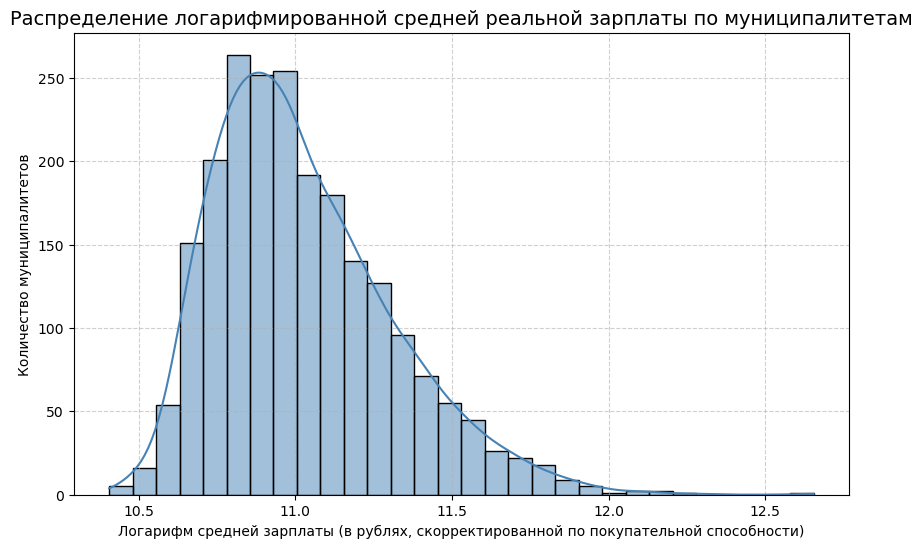

In [124]:
# Усредняем (или просто берём уникальные значения) зарплаты по муниципалитету
df_municipal = df.groupby('territory_id', as_index=False)['salary_real_log'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(df_municipal['salary_real_log'], bins=30, kde=True, color='steelblue')

plt.title('Распределение логарифмированной средней реальной зарплаты по муниципалитетам', fontsize=14)
plt.xlabel('Логарифм средней зарплаты (в рублях, скорректированной по покупательной способности)')
plt.ylabel('Количество муниципалитетов')

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



Распределение логарифмированных значений средней дисконтированной заработной платы по муниципалитетам близко к нормальному, с небольшим правосторонним перекосом. Это указывает на то, что большинство муниципалитетов имеют схожие уровни заработной платы, скорректированные по покупательной способности, тогда как небольшое число территорий характеризуется значительно более высокими значениями.

Основная масса наблюдений сосредоточена в диапазоне логарифмов от 9,5 до 10,1, что соответствует приблизительно 13–25 тыс. рублей в пересчёте на покупательную способность. Правая часть распределения отражает редкие случаи муниципалитетов с зарплатами свыше 35 тыс. рублей.

После логарифмирования распределение стало визуально симметричнее и ближе к нормальному, что подтверждает корректность применения данного преобразования для последующего статистического анализа и построения моделей.

## Посмотрим на распределение безналичных платежей по муниципалитетам.

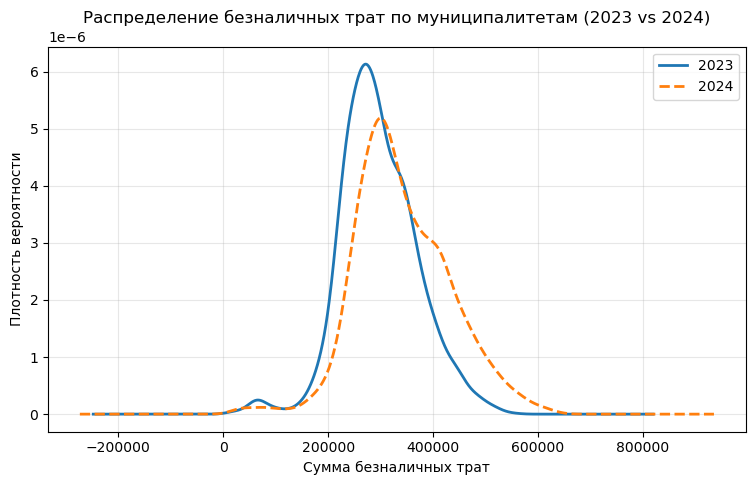

In [125]:
# --- 1. Берем только строки с "Все категории" ---
df_total = df[df['category'] == 'Все категории'].copy()

# --- 2. Добавляем колонку с годом ---
df_total['year'] = df_total['date'].dt.year

# --- 3. Фильтруем нужные годы ---
df_filtered = df_total[df_total['year'].isin([2023, 2024])]

# --- 4. Считаем сумму трат по муниципалитетам за каждый год ---
yearly_sums = (
    df_filtered
    .groupby(['territory_id', 'year'], as_index=False)['consumption_real']
    .sum()
)

# --- 5. Разделяем на два массива ---
cons_2023 = yearly_sums.loc[yearly_sums['year'] == 2023, 'consumption_real']
cons_2024 = yearly_sums.loc[yearly_sums['year'] == 2024, 'consumption_real']

# --- 6. Строим распределения ---
plt.figure(figsize=(9, 5))

# KDE-графики (плавная кривая)
cons_2023.plot(kind='kde', label='2023', linewidth=2)
cons_2024.plot(kind='kde', label='2024', linewidth=2, linestyle='--')

plt.title('Распределение безналичных трат по муниципалитетам (2023 vs 2024)')
plt.xlabel('Сумма безналичных трат')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



## Посмотрим на динамику % безналичных полатежей от зарплаты

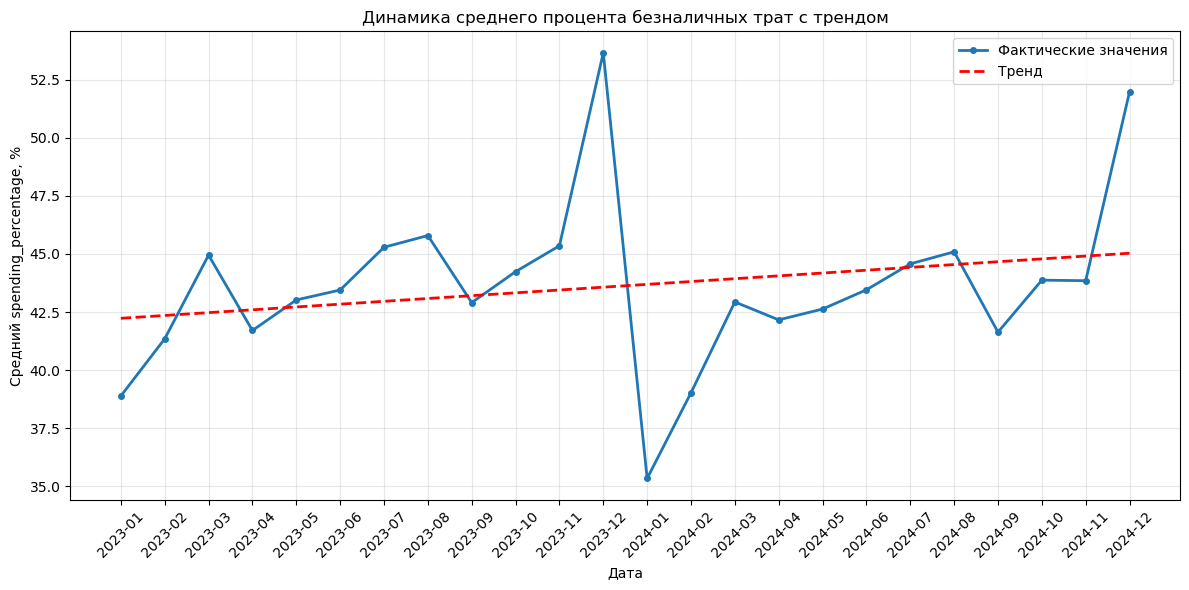

Тренд: 0.122% в месяц


In [126]:
# Фильтруем данные и агрегируем по дате
time_series = (
    df[(df['category'] == 'Все категории') & df['spending_percentage'].notnull()]
    .groupby('date', as_index=False)['spending_percentage']
    .mean()
    .sort_values('date')
)

# Линейный тренд
X = np.arange(len(time_series)).reshape(-1, 1)
y = time_series['spending_percentage'].values
model = LinearRegression().fit(X, y)
trend = model.predict(X)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(time_series['date'].astype(str), y, marker='o', linewidth=2, markersize=4, label='Фактические значения')
plt.plot(time_series['date'].astype(str), trend, 'r--', linewidth=2, label='Тренд')
plt.title('Динамика среднего процента безналичных трат с трендом')
plt.xlabel('Дата')
plt.ylabel('Средний spending_percentage, %')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Тренд: {model.coef_[0]:.3f}% в месяц")


## Теперь посмотрим на динамику расходов по категориям в % от общего дохода.

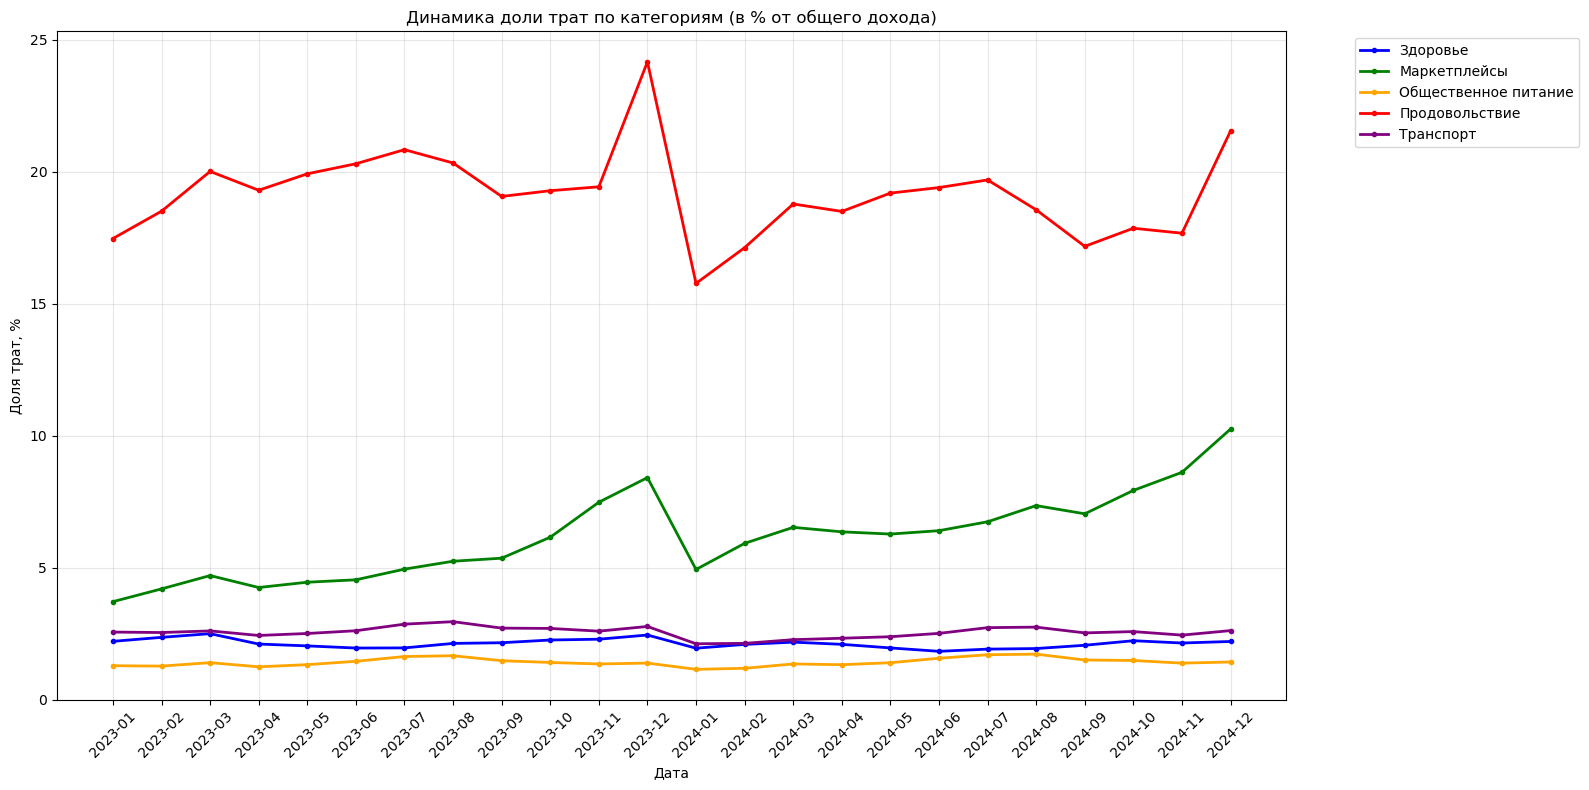

Средняя доля трат по категориям:
  Продовольствие: 19.2%
  Маркетплейсы: 6.2%
  Транспорт: 2.5%
  Здоровье: 2.1%
  Общественное питание: 1.4%


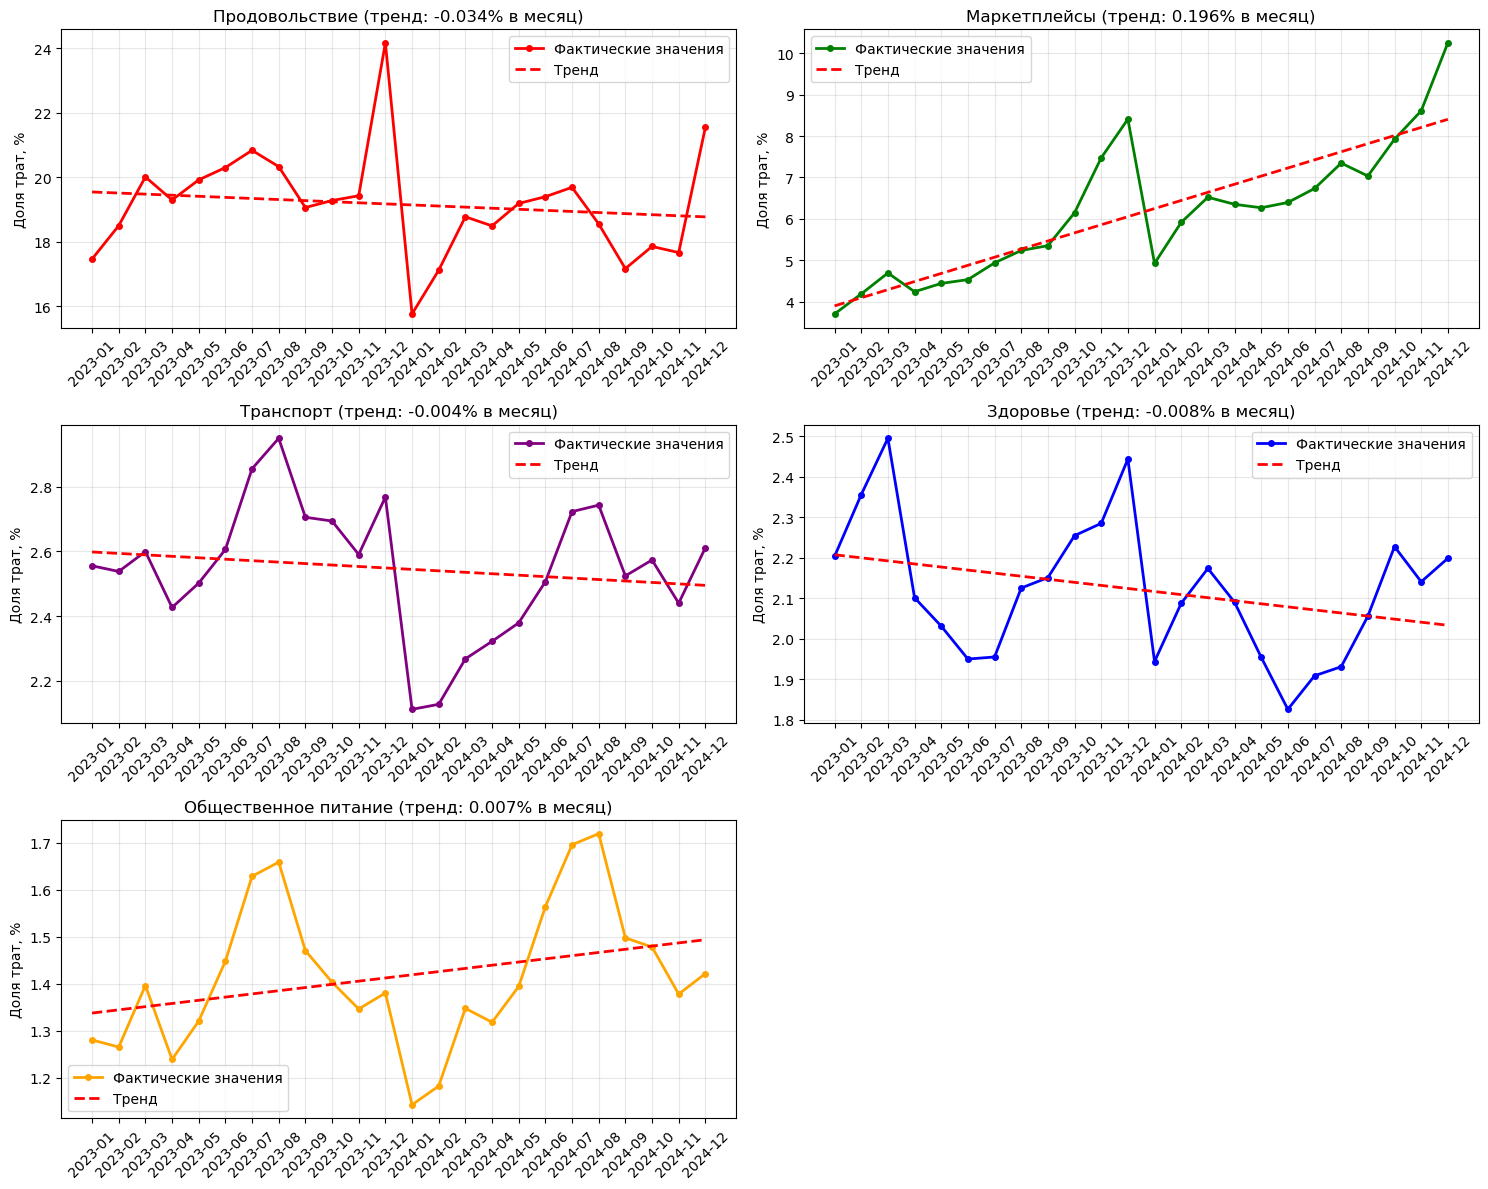


Общая статистика:
Количество категорий: 5
Период наблюдения: 2023-01 - 2024-12
Общее количество наблюдений: 120


In [127]:
# --- 1. Фильтруем данные ---
# Исключаем "Все категории" и убираем строки с пропущенными значениями
category_data = df[
    (df['category'] != 'Все категории') & 
    (df['spending_percentage'].notnull())
].copy()

# --- 2. Преобразуем spending_percentage в числовой формат ---
category_data['spending_percentage'] = category_data['spending_percentage'].astype(float)

# --- 3. Группируем по дате и категории, считаем средний процент ---
time_series_category = (
    category_data
    .groupby(['date', 'category'])['spending_percentage']
    .mean()
    .reset_index()
    .sort_values('date')
)

# --- 4. Создаем отдельные датафреймы по каждой категории ---
categories = time_series_category['category'].unique()
category_dfs = {
    category: time_series_category[time_series_category['category'] == category].sort_values('date')
    for category in categories
}

# --- 5. Фиксированные цвета для ключевых категорий ---
category_colors = {
    'Продовольствие': 'red',
    'Здоровье': 'blue', 
    'Маркетплейсы': 'green',
    'Общественное питание': 'orange',
    'Транспорт': 'purple'
}

# --- 6. График динамики по всем категориям ---
plt.figure(figsize=(16, 8))
for category in categories:
    df_cat = category_dfs[category]
    color = category_colors.get(category, 'gray')  # Серый для прочих категорий
    plt.plot(
        df_cat['date'].astype(str),
        df_cat['spending_percentage'],
        marker='o',
        linewidth=2,
        markersize=3,
        label=category,
        color=color
    )

plt.title('Динамика доли трат по категориям (в % от общего дохода)')
plt.xlabel('Дата')
plt.ylabel('Доля трат, %')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 7. Статистика по категориям ---
print("Средняя доля трат по категориям:")
category_means = (
    time_series_category
    .groupby('category')['spending_percentage']
    .mean()
    .sort_values(ascending=False)
)
for category, mean_value in category_means.items():
    print(f"  {category}: {mean_value:.1f}%")

# --- 8. Отдельные графики для топ-5 категорий с трендом ---
top_categories = category_means.head(5).index
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, category in enumerate(top_categories):
    df_cat = category_dfs[category]
    color = category_colors.get(category, 'gray')
    
    # Линейная регрессия для тренда
    X = np.arange(len(df_cat)).reshape(-1, 1)
    y = df_cat['spending_percentage'].values
    model = LinearRegression()
    model.fit(X, y)
    trend = model.predict(X)
    
    axes[i].plot(
        df_cat['date'].astype(str),
        df_cat['spending_percentage'],
        marker='o',
        linewidth=2,
        markersize=4,
        label='Фактические значения',
        color=color
    )
    axes[i].plot(
        df_cat['date'].astype(str),
        trend,
        'r--',
        linewidth=2,
        label='Тренд'
    )
    axes[i].set_title(f'{category} (тренд: {model.coef_[0]:.3f}% в месяц)')
    axes[i].set_ylabel('Доля трат, %')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Убираем лишнюю ось, если категорий меньше 6
if len(top_categories) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

# --- 9. Общая статистика ---
print(f"\nОбщая статистика:")
print(f"Количество категорий: {len(categories)}")
print(f"Период наблюдения: {time_series_category['date'].min()} - {time_series_category['date'].max()}")
print(f"Общее количество наблюдений: {len(time_series_category)}")


## Посмотрмм на 1 и 4 квартили муниципалитетов по номинальной зарплате.

Отберем данные только за 2024 год.

In [128]:
# --- 1. Отбор данных за 2024 год ---
df_2024 = df[df['year'] == 2024].copy()
print(f"Размер выборки за 2024 год: {df_2024.shape}")

# --- 2. Группировка по муниципалитету ---
df_2024_mean = (
    df_2024
    .groupby(['territory_id', 'municipal_district_name', 'region_name_x'], as_index=False)
    .mean(numeric_only=True)
)

print(f"Размер агрегированного датасета df_2024_mean: {df_2024_mean.shape}")


Размер выборки за 2024 год: (150402, 35)
Размер агрегированного датасета df_2024_mean: (2127, 33)


In [129]:
# --- 3. Проверяем данные ---
df_2024_mean.head(7)

,territory_id,municipal_district_name,region_name_x,consumption,oktmo,salary,spending_percentage,year,market_access,total_population,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,eco_spending_thousands,roads_defective_percent,building_permits,index_purchasing_power,salary_real,consumption_real,salary_real_log,category_percentage,eco_spending_per_1000,building_permits_per_1000
0,1,городской округ город Майкоп,Республика Адыгея,8332.694444,79701000.0,57440.5,14.508333,2024.0,309.6,161898.0,21702.0,120831.0,84.77,-0.90,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,84.9,67656.7,9814.719444,11.122202,28.515278,6170.09,0.33
1,2,городской округ город Адыгейск,Республика Адыгея,6242.750000,79703000.0,47407.2,13.172222,2024.0,322.8,15661.0,2233.0,12091.0,84.41,-1.58,0.00,0.40,0.35,0.67,1.29,0.48,-0.25,-0.09,0.67,45777.0,17.0,17.0,84.9,55838.9,7353.059722,10.930226,28.866667,2922.99,1.09
2,3,Гиагинский муниципальный район,Республика Адыгея,6474.472222,79605000.0,54547.7,11.866667,2024.0,315.2,31872.0,28452.0,0.0,0.00,0.50,0.32,-0.06,0.05,0.10,0.74,0.46,0.03,0.18,0.36,31563.0,7.1,20.0,84.9,64249.4,7625.997222,11.070528,29.141667,990.30,0.63
3,4,Кошехабльский муниципальный район,Республика Адыгея,6882.541667,79615000.0,51262.1,13.422222,2024.0,315.5,30319.0,27181.0,0.0,0.00,1.67,1.17,0.12,0.18,1.86,0.79,0.26,0.22,0.73,0.80,27752.0,1.6,4.0,84.9,60379.4,8106.650000,11.008403,28.734722,915.33,0.13
4,5,Красногвардейский муниципальный район,Республика Адыгея,6461.111111,79618000.0,48849.1,13.226389,2024.0,320.2,32095.0,29069.0,0.0,0.00,1.32,0.54,0.20,-0.19,1.10,0.46,0.87,-0.52,0.39,0.52,9249.0,12.5,11.0,84.9,57537.2,7610.263889,10.960187,28.920833,288.18,0.34
5,6,Майкопский муниципальный район,Республика Адыгея,7750.013889,79622000.0,47965.8,16.161111,2024.0,308.1,59156.0,52064.0,0.0,0.00,1.21,1.61,0.76,0.12,1.75,1.25,1.03,0.30,0.83,1.07,19741.0,18.1,40.0,84.9,56496.8,9128.405556,10.941939,28.958333,333.71,0.68
6,7,Тахтамукайский муниципальный район,Республика Адыгея,11164.708333,79630000.0,75708.3,14.745833,2024.0,324.7,131043.0,42435.0,78871.0,65.02,4.94,3.00,2.50,1.25,4.95,2.18,2.51,0.84,2.87,2.67,160223.0,18.2,105.0,84.9,89173.5,13150.422222,11.398339,28.236111,1222.67,0.80


In [130]:
# --- 1. Копируем данные ---
df_q = df_2024_mean.copy()

# --- 2. Убираем пропуски в ключевых показателях дохода ---
df_q = df_q.dropna(subset=['salary_real'])

# --- 3. Заполняем пропуски в миграционных показателях медианой ---
df_q[['migration_index_Женщины_total', 'migration_index_Мужчины_total']] = (
    df_q[['migration_index_Женщины_total', 'migration_index_Мужчины_total']]
    .apply(lambda x: x.fillna(x.median()))
)

# --- 4. Создаём квартильные группы по реальному доходу ---
df_q['salary_quartile'] = pd.qcut(
    df_q['salary_real'],
    4,
    labels=['Q1', 'Q2', 'Q3', 'Q4']
)

# --- 5. Список показателей для сравнения ---
cols_to_compare = [
    'salary_real', 'consumption_real',
    'market_access', 'total_population', 'urban_population_pct',
    'migration_index_Женщины_total', 'migration_index_Мужчины_total',
    'roads_defective_percent', 'eco_spending_per_1000', 'building_permits_per_1000'
]

# --- 6. Считаем средние показатели в каждой группе ---
quartile_means = (
    df_q.groupby('salary_quartile', observed=True)[cols_to_compare]
    .mean()
    .round(2)
)

# --- 7. Добавляем строку со средними по всем муниципалитетам ---
overall_mean = df_q[cols_to_compare].mean().rename('Среднее по всем муниципалитетам').round(2)
quartile_means = pd.concat([quartile_means, overall_mean.to_frame().T])

# --- 8. Формируем информативные русские подписи для квартилей ---
quartile_labels = {
    'Q1': '25% муниципалитетов с самыми низкими зарплатами',
    'Q2': '25% муниципалитетов с зарплатами ниже среднего',
    'Q3': '25% муниципалитетов с зарплатами выше среднего',
    'Q4': '25% муниципалитетов с самыми высокими зарплатами'
}


# --- 9. Переименуем индексы таблицы quartile_means ---
# Для строки overall_mean оставим название на русском
new_index = []
for idx in quartile_means.index:
    if idx in quartile_labels:
        new_index.append(quartile_labels[idx])
    else:
        new_index.append(idx)  # например 'Среднее по всем муниципалитетам'
quartile_means.index = new_index

# --- 10. Переведём имена столбцов на русский ---
col_rename_map = {
    'salary_real': 'Реальная зарплата',
    'consumption_real': 'Реальные траты',
    'market_access': 'Доступность рынков',
    'total_population': 'Население',
    'urban_population_pct': 'Процент городского населения',
    'migration_index_Женщины_total': 'Миграция женщин (общая)',
    'migration_index_Мужчины_total': 'Миграция мужчин (общая)',
    'roads_defective_percent': 'Доля местных дорог в ненормативном состоянии, %',
    'eco_spending_per_1000': 'Бюджетные расходы на экологию на 1000 чел (тыс. руб?)',
    'building_permits_per_1000': 'Количество выданных разрешений на строительство на 1000 чел'
}
quartile_means = quartile_means.rename(columns=col_rename_map)

# --- 11. Считаем отклонение 1 и 4 квартиля от среднего (в %) на тех же русских названиях ---
# Возвращаем индексы к ключевым для вычислений (Q1/Q4) — но потом заменим на русские метки для отображения
quartile_means_calc = (
    df_q.groupby('salary_quartile', observed=True)[cols_to_compare]
    .mean()
)
overall_mean_calc = df_q[cols_to_compare].mean()

deviation = ((quartile_means_calc - overall_mean_calc) / overall_mean_calc * 100).round(1)
# Оставляем только Q1 и Q4
deviation = deviation.loc[['Q1', 'Q4']]

# Переименуем колонки в deviation на русский
deviation = deviation.rename(columns=col_rename_map)

# Переименуем индекс Q1/Q4 в информативные метки
deviation.index = [quartile_labels['Q1'], quartile_labels['Q4']]

# --- 12. Выводим результат ---
print("=== Средние значения по квартилям реального дохода (русские подписи) ===")
display(quartile_means)

print("\n=== Отклонение от среднего (в %) для нижнего и верхнего квартилей ===")
display(deviation)



=== Средние значения по квартилям реального дохода (русские подписи) ===


,Реальная зарплата,Реальные траты,Доступность рынков,Население,Процент городского населения,Миграция женщин (общая),Миграция мужчин (общая),"Доля местных дорог в ненормативном состоянии, %",Бюджетные расходы на экологию на 1000 чел (тыс. руб?),Количество выданных разрешений на строительство на 1000 чел
25% муниципалитетов с самыми низкими зарплатами,48715.25,6720.02,303.21,21248.19,27.02,-0.48,-0.32,51.82,1083.47,0.49
25% муниципалитетов с зарплатами ниже среднего,58371.07,7746.71,313.90,31526.13,40.03,-0.25,-0.10,51.19,2641.66,0.47
25% муниципалитетов с зарплатами выше среднего,70501.52,8665.27,313.93,61370.14,56.42,-0.06,-0.01,47.34,6150.19,0.50
25% муниципалитетов с самыми высокими зарплатами,101805.60,10087.90,376.45,116433.87,77.16,0.22,0.18,41.24,20829.18,0.64
Среднее по всем муниципалитетам,69848.05,8304.81,326.51,55561.95,49.52,-0.14,-0.06,48.48,8175.37,0.52



=== Отклонение от среднего (в %) для нижнего и верхнего квартилей ===


,Реальная зарплата,Реальные траты,Доступность рынков,Население,Процент городского населения,Миграция женщин (общая),Миграция мужчин (общая),"Доля местных дорог в ненормативном состоянии, %",Бюджетные расходы на экологию на 1000 чел (тыс. руб?),Количество выданных разрешений на строительство на 1000 чел
25% муниципалитетов с самыми низкими зарплатами,-30.3,-19.1,-7.1,-61.8,-45.4,238.9,411.5,6.9,-86.7,-6.5
25% муниципалитетов с самыми высокими зарплатами,45.8,21.5,15.3,109.6,55.8,-253.4,-393.3,-14.9,154.8,22.8


In [131]:
# --- 11. Добавляем квартильную метку в исходный датасет df ---

# Берём только нужные колонки: идентификатор и квартиль
quartile_labels = df_q[['territory_id', 'salary_quartile']].copy()

# Объединяем по territory_id
df = df.merge(quartile_labels, on='territory_id', how='left')

In [132]:
df.head()

,date,territory_id,category,consumption,oktmo,municipal_district_name,region_name_x,salary,spending_percentage,year,market_access,total_population,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,eco_spending_thousands,roads_defective_percent,building_permits,index_purchasing_power,salary_real,consumption_real,salary_real_log,category_percentage,eco_spending_per_1000,building_permits_per_1000,salary_quartile
0,2023-01,1,Продовольствие,7692.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,15.9,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,9403.4,10.987991,35.6,6099.71,0.32,Q3
1,2023-01,1,Здоровье,1271.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,2.6,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,1553.8,10.987991,5.9,6099.71,0.32,Q3
2,2023-01,1,Маркетплейсы,2505.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,5.2,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,3062.3,10.987991,11.6,6099.71,0.32,Q3
3,2023-01,1,Общественное питание,1142.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,2.4,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,1396.1,10.987991,5.3,6099.71,0.32,Q3
4,2023-01,1,Транспорт,1718.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,3.6,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,2100.2,10.987991,8.0,6099.71,0.32,Q3


## Посмотрим на муниципалитеты, которые относятся к первому и четвертому квартилю распределения по дисконтированным зарплатам.

In [133]:
# --- 1. Копируем исходный датафрейм ---
df_q = df_2024_mean.copy()

# --- 2. Убираем пропуски по доходу ---
df_q = df_q.dropna(subset=['salary_real'])

# --- 3. Создаём квартильные группы по реальному доходу ---
df_q['salary_quartile'] = pd.qcut(
    df_q['salary_real'], 
    4, 
    labels=['Q1', 'Q2', 'Q3', 'Q4']
)

# --- 4. Выделяем муниципалитеты из 1 и 4 квартиля ---
low_income_mun = df_q[df_q['salary_quartile'] == 'Q1']['territory_id']
high_income_mun = df_q[df_q['salary_quartile'] == 'Q4']['territory_id']

# --- 5. Формируем два датафрейма из полного df_2024_mean ---
df_low_income = df_2024_mean[df_2024_mean['territory_id'].isin(low_income_mun)].copy()
df_high_income = df_2024_mean[df_2024_mean['territory_id'].isin(high_income_mun)].copy()

# --- 6. Проверим размеры и пример данных ---
print(f"Муниципалитетов в Q1 (низкий доход): {df_low_income.shape[0]}")
print(f"Муниципалитетов в Q4 (высокий доход): {df_high_income.shape[0]}")

display(df_low_income.head(3))
display(df_high_income.head(3))


Муниципалитетов в Q1 (низкий доход): 532
Муниципалитетов в Q4 (высокий доход): 532


,territory_id,municipal_district_name,region_name_x,consumption,oktmo,salary,spending_percentage,year,market_access,total_population,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,eco_spending_thousands,roads_defective_percent,building_permits,index_purchasing_power,salary_real,consumption_real,salary_real_log,category_percentage,eco_spending_per_1000,building_permits_per_1000
8,9,Шовгеновский муниципальный район,Республика Адыгея,6025.944444,79640000.0,42776.6,14.091667,2024.0,314.3,16287.0,14690.0,0.0,0.0,2.31,0.68,-0.09,0.20,1.38,0.22,0.34,0.43,0.67,0.55,855.0,9.5,2.0,84.9,50384.7,7097.690278,10.827443,28.700000,52.50,0.12
28,30,Абзелиловский муниципальный район,Республика Башкортостан,5269.083333,80601000.0,52673.4,10.004167,2024.0,294.7,43983.0,41126.0,0.0,0.0,-3.11,-0.79,-0.14,-0.15,-2.48,0.64,0.30,-0.18,-1.03,-0.45,13657.0,2.2,26.0,99.7,52831.9,5284.931944,10.874870,28.254167,310.51,0.59
30,32,Архангельский муниципальный район,Республика Башкортостан,6309.430556,80603000.0,46871.6,13.462500,2024.0,316.6,16616.0,14864.0,0.0,0.0,-2.66,-2.23,0.27,0.14,-1.84,-0.20,0.34,0.25,-0.88,-0.31,NaN,20.8,5.0,99.7,47012.6,6328.416667,10.758171,28.793056,NaN,0.30


,territory_id,municipal_district_name,region_name_x,consumption,oktmo,salary,spending_percentage,year,market_access,total_population,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,eco_spending_thousands,roads_defective_percent,building_permits,index_purchasing_power,salary_real,consumption_real,salary_real_log,category_percentage,eco_spending_per_1000,building_permits_per_1000
6,7,Тахтамукайский муниципальный район,Республика Адыгея,11164.708333,79630000.0,75708.3,14.745833,2024.0,324.7,131043.0,42435.0,78871.0,65.02,4.94,3.00,2.50,1.25,4.95,2.18,2.51,0.84,2.87,2.67,160223.0,18.2,105.0,84.9,89173.5,13150.422222,11.398339,28.236111,1222.67,0.80
7,8,Теучежский муниципальный район,Республика Адыгея,9152.388889,79633000.0,74168.0,12.340278,2024.0,317.4,22260.0,13459.0,6701.0,33.24,2.12,0.63,0.24,0.11,1.25,0.82,0.31,0.00,0.67,0.62,450755.0,12.1,15.0,84.9,87359.2,10780.201389,11.377784,28.794444,20249.55,0.67
9,10,городской округ город Горно-Алтайск,Республика Алтай,9110.388889,84701000.0,73499.3,12.393056,2024.0,213.5,64508.0,0.0,59923.0,100.00,-0.73,-0.76,-0.60,0.04,-1.78,-0.80,-0.53,0.24,-0.53,-0.93,101788.0,50.1,NaN,80.4,91417.0,11331.327778,11.423187,28.220833,1577.91,NaN


In [134]:
df_low_income['region_name_x'].value_counts(normalize = True).head(10).round(2)

region_name_x
Омская область             0.06
Республика Башкортостан    0.05
Саратовская область        0.05
Красноярский край          0.05
Тюменская область          0.04
Республика Татарстан       0.04
Кировская область          0.03
Нижегородская область      0.03
Оренбургская область       0.03
Иркутская область          0.03
Name: proportion, dtype: float64

In [135]:
df_high_income['region_name_x'].value_counts(normalize = True).head(10)

region_name_x
Москва                                      0.231203
Санкт-Петербург                             0.135338
Московская область                          0.052632
Республика Саха (Якутия)                    0.035714
Приморский край                             0.031955
Хабаровский край                            0.028195
Ханты-Мансийский автономный округ — Югра    0.026316
Камчатский край                             0.020677
Красноярский край                           0.016917
Ямало-Ненецкий автономный округ             0.016917
Name: proportion, dtype: float64

## Кластеризируем муниципалитеты на основании процентов категорий от общего объема безналичных трат. 

=== Средние значения по всем муниципалитетам (по категориям) ===


category
Здоровье                 4.86
Маркетплейсы            13.80
Общественное питание     3.32
Продовольствие          43.79
Транспорт                5.85
dtype: float64

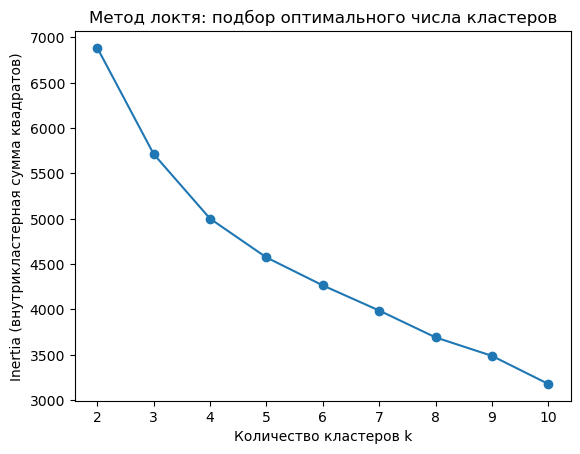

In [136]:
# --- 1. Берём только нужные категории (без 'Все категории') ---
df_cat = df[df['category'] != 'Все категории'].copy()

# --- 2. Считаем среднюю долю категории по каждому муниципалитету ---
df_mean = (
    df_cat.groupby(['territory_id', 'category'])['category_percentage']
    .mean()
    .reset_index()
)

# --- 3. Поворачиваем таблицу в “широкий” формат ---
df_pivot = (
    df_mean.pivot(index='territory_id', columns='category', values='category_percentage')
    .fillna(0)
)

# --- 4. Считаем средние значения по всем муниципалитетам ---
mean_by_category = df_pivot.mean()

print("=== Средние значения по всем муниципалитетам (по категориям) ===")
display(mean_by_category.round(2))

# --- 5. Стандартизируем: выражаем каждое значение как отклонение от среднего ---
# (муниципалитеты с > 0 — выше среднего, < 0 — ниже среднего)
df_relative = df_pivot - mean_by_category

# --- 6. Масштабируем для кластеризации (z-оценка) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_relative)

# --- 7. Проверяем оптимальное число кластеров методом локтя ---
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.title('Метод локтя: подбор оптимального числа кластеров')
plt.xlabel('Количество кластеров k')
plt.ylabel('Inertia (внутрикластерная сумма квадратов)')
plt.show()



Размер кластеров:
cluster
1    917
2    510
3    763
Name: count, dtype: int64 

=== Профили кластеров (отклонения от среднего) ===


category,Здоровье,Маркетплейсы,Общественное питание,Продовольствие,Транспорт
cluster,,,,,
1,0.01,2.71,-1.51,3.45,-0.79
2,0.67,-0.86,3.26,-9.57,1.54
3,-0.46,-2.68,-0.37,2.24,-0.08


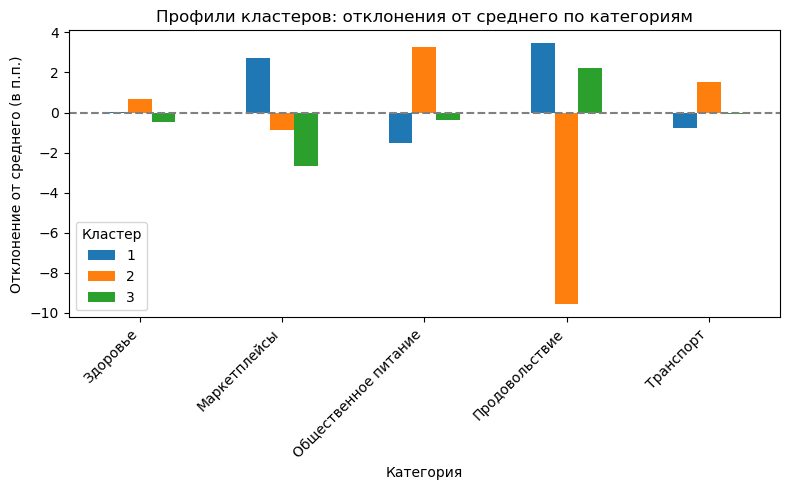

In [137]:
# --- 8. Кластеризация (выбери нужное k, например 3) ---
k = 3

# Выбираем только числовые признаки для кластеризации
X = df_relative.select_dtypes(include='number')

# Масштабируем те же строки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучаем модель и добавляем кластер к df_relative
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
df_relative['cluster'] = kmeans.fit_predict(X_scaled) + 1  # кластеры с 1

# --- 9. Считаем профиль кластеров ---
cluster_profiles = df_relative.groupby('cluster').mean().round(2)

print("\nРазмер кластеров:")
print(df_relative['cluster'].value_counts().sort_index(), "\n")

print("=== Профили кластеров (отклонения от среднего) ===")
display(cluster_profiles)

# --- 10. Визуализация профилей кластеров ---
ax = cluster_profiles.T.plot(kind='bar', figsize=(8,5))
plt.axhline(0, color='gray', linestyle='--')
plt.title('Профили кластеров: отклонения от среднего по категориям')
plt.ylabel('Отклонение от среднего (в п.п.)')
plt.xlabel('Категория')
plt.legend(title='Кластер')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


В результате кластеризации муниципалитетов по структуре безналичных расходов (относительно среднего уровня по всем муниципалитетам) было выделено три кластера, различающиеся по профилю потребительского поведения.

Кластер 0 — “Маркетплейсно-продовольственный”
Муниципалитеты этого кластера характеризуются повышенной долей безналичных трат на маркетплейсах (+2,7 п.п.) и на продовольственные товары (+3,5 п.п.) по сравнению со средним уровнем. Расходы на общественное питание несколько ниже среднего (–1,5 п.п.), как и на транспорт (–0,8 п.п.). Можно предположить, что это населённые пункты с развитой онлайн-торговлей и стабильным потреблением продуктов питания, но умеренной сферой услуг и транспорта.

Кластер 1 — “Сфера услуг и транспорта вместо продуктов”
Для этого кластера характерна повышенная доля трат на общественное питание (+3,3 п.п.) и транспорт (+1,5 п.п.), при этом расходы на продовольственные товары существенно ниже среднего (–9,6 п.п.). Можно предположить, что в таких муниципалитетах выше доля расходов на сервисы и досуг, что может быть связано с более высоким уровнем урбанизации или присутствием крупных городов.

Кластер 2 — “Сдержанное потребление”
Муниципалитеты этого кластера демонстрируют значения ниже среднего по большинству категорий (особенно по маркетплейсам –2,7 п.п. и по здоровью –0,5 п.п.), при этом расходы на продовольствие немного выше среднего (+2,2 п.п.). Такой профиль может указывать на более консервативное и традиционное потребительское поведение, где основная часть трат приходится на базовые нужды.

Добавим кластеры в основной датасет.

In [138]:
# --- 1. Добавляем метки кластеров в df_relative ---
cluster_labels = df_relative.copy()
cluster_labels['cluster'] = kmeans.labels_

# --- 2. Возвращаем territory_id из индекса в столбец ---
cluster_labels = cluster_labels.reset_index()[['territory_id', 'cluster']]

# --- 3. Объединяем с исходным датасетом ---
df_with_clusters = df.merge(cluster_labels, on='territory_id', how='left')

# --- 4. Проверяем ---
print("Размер нового датасета:", df_with_clusters.shape)
print("Количество муниципалитетов без метки кластера:", df_with_clusters['cluster'].isna().sum())

display(df_with_clusters.head())



Размер нового датасета: (303126, 37)
Количество муниципалитетов без метки кластера: 0


,date,territory_id,category,consumption,oktmo,municipal_district_name,region_name_x,salary,spending_percentage,year,market_access,total_population,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,eco_spending_thousands,roads_defective_percent,building_permits,index_purchasing_power,salary_real,consumption_real,salary_real_log,category_percentage,eco_spending_per_1000,building_permits_per_1000,salary_quartile,cluster
0,2023-01,1,Продовольствие,7692.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,15.9,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,9403.4,10.987991,35.6,6099.71,0.32,Q3,1
1,2023-01,1,Здоровье,1271.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,2.6,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,1553.8,10.987991,5.9,6099.71,0.32,Q3,1
2,2023-01,1,Маркетплейсы,2505.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,5.2,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,3062.3,10.987991,11.6,6099.71,0.32,Q3,1
3,2023-01,1,Общественное питание,1142.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,2.4,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,1396.1,10.987991,5.3,6099.71,0.32,Q3,1
4,2023-01,1,Транспорт,1718.0,79701000,городской округ город Майкоп,Республика Адыгея,48392.4,3.6,2023,309.6,163766.0,21702.0,120831.0,84.77,-0.9,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,81.8,59159.4,2100.2,10.987991,8.0,6099.71,0.32,Q3,1


## Посмотрим на связь между доходом и процентом безналичных платежей.

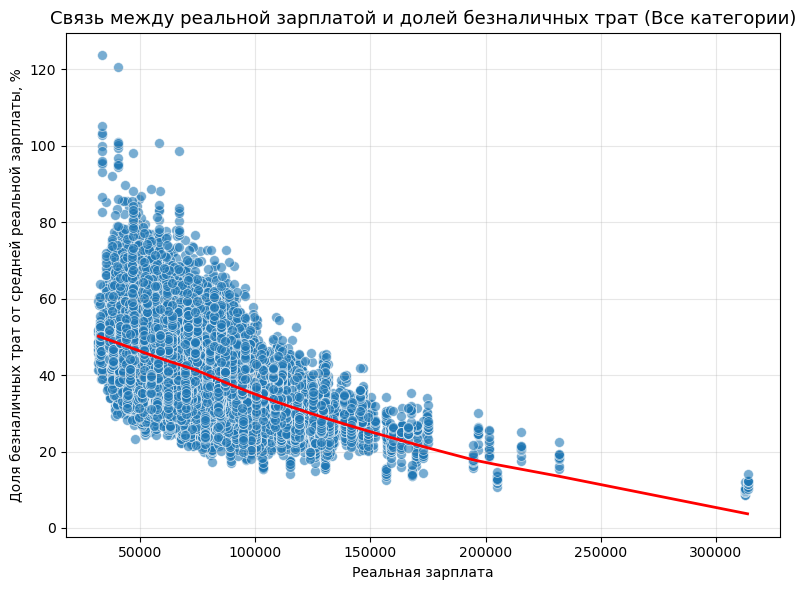

In [139]:
# --- 1. Отбираем только строки с категорией "Все категории" ---
df_all = df[df['category'] == 'Все категории'].copy()

# --- 2. Убираем пропуски ---
df_all = df_all.dropna(subset=['salary_real', 'spending_percentage'])

# --- 3. Строим scatter plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_all,
    x='salary_real',
    y='spending_percentage',
    alpha=0.6,
    s=50
)

# --- 4. Добавляем сглаженную нелинейную линию тренда ---
sns.regplot(
    data=df_all,
    x='salary_real',
    y='spending_percentage',
    scatter=False,
    lowess=True,
    line_kws={'color': 'red', 'lw': 2}  # толщина линии
)

# --- 5. Настройки внешнего вида ---
plt.title('Связь между реальной зарплатой и долей безналичных трат (Все категории)', fontsize=13)
plt.xlabel('Реальная зарплата')
plt.ylabel('Доля безналичных трат от средней реальной зарплаты, %')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Посмотрим. в каких МО траты превышают зарплату.

In [140]:
unique_ids = df.loc[
    (df['category'] == 'Все категории') & 
    (df['spending_percentage'] > 100),
    'territory_id'
].unique()

print(unique_ids)


[1783 3013]


Посмотрим, когда муниципалитеты тратили больше зарплаты.

In [141]:
df[(df['territory_id'].isin([1783, 3013])) & (df['spending_percentage'] > 100)]

,date,territory_id,category,consumption,oktmo,municipal_district_name,region_name_x,salary,spending_percentage,year,market_access,total_population,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,eco_spending_thousands,roads_defective_percent,building_permits,index_purchasing_power,salary_real,consumption_real,salary_real_log,category_percentage,eco_spending_per_1000,building_permits_per_1000,salary_quartile
196067,2023-12,1783,Все категории,44494.0,58649000,Псковский муниципальный район,Псковская область,44189.9,100.7,2023,414.2,43640.0,40690.0,0.0,0.00,-0.49,-0.30,-0.10,0.00,-0.41,-0.08,0.0,0.02,0.00,0.02,145425.0,29.9,39.0,76.0,58144.6,58544.7,10.970688,100.0,3332.38,0.89,Q3
302909,2023-08,3013,Все категории,40788.0,46771000,городской округ Солнечногорск,Московская область,39651.4,102.9,2023,465.6,154721.0,53487.0,68471.0,56.14,3.86,2.62,1.64,0.92,2.63,2.60,1.4,0.54,2.24,2.02,2366914.0,27.7,113.0,117.8,33659.9,34624.8,10.424062,100.0,15297.95,0.73,Q1
302921,2023-10,3013,Все категории,41019.0,46771000,городской округ Солнечногорск,Московская область,39651.4,103.4,2023,465.6,154721.0,53487.0,68471.0,56.14,3.86,2.62,1.64,0.92,2.63,2.60,1.4,0.54,2.24,2.02,2366914.0,27.7,113.0,117.8,33659.9,34820.9,10.424062,100.0,15297.95,0.73,Q1
302927,2023-11,3013,Все категории,41694.0,46771000,городской округ Солнечногорск,Московская область,39651.4,105.2,2023,465.6,154721.0,53487.0,68471.0,56.14,3.86,2.62,1.64,0.92,2.63,2.60,1.4,0.54,2.24,2.02,2366914.0,27.7,113.0,117.8,33659.9,35393.9,10.424062,100.0,15297.95,0.73,Q1
302933,2023-12,3013,Все категории,49015.0,46771000,городской округ Солнечногорск,Московская область,39651.4,123.6,2023,465.6,154721.0,53487.0,68471.0,56.14,3.86,2.62,1.64,0.92,2.63,2.60,1.4,0.54,2.24,2.02,2366914.0,27.7,113.0,117.8,33659.9,41608.7,10.424062,100.0,15297.95,0.73,Q1
302981,2024-08,3013,Все категории,48052.0,46771000,городской округ Солнечногорск,Московская область,47588.8,101.0,2024,465.6,135509.0,53487.0,68471.0,56.14,3.86,2.62,1.64,0.92,2.63,2.60,1.4,0.54,2.24,2.02,2366914.0,27.7,113.0,118.3,40227.2,40618.8,10.602299,100.0,17466.84,0.83,Q1
302993,2024-10,3013,Все категории,47645.0,46771000,городской округ Солнечногорск,Московская область,47588.8,100.1,2024,465.6,135509.0,53487.0,68471.0,56.14,3.86,2.62,1.64,0.92,2.63,2.60,1.4,0.54,2.24,2.02,2366914.0,27.7,113.0,118.3,40227.2,40274.7,10.602299,100.0,17466.84,0.83,Q1
302999,2024-11,3013,Все категории,47945.0,46771000,городской округ Солнечногорск,Московская область,47588.8,100.7,2024,465.6,135509.0,53487.0,68471.0,56.14,3.86,2.62,1.64,0.92,2.63,2.60,1.4,0.54,2.24,2.02,2366914.0,27.7,113.0,118.3,40227.2,40528.3,10.602299,100.0,17466.84,0.83,Q1
303005,2024-12,3013,Все категории,57410.0,46771000,городской округ Солнечногорск,Московская область,47588.8,120.6,2024,465.6,135509.0,53487.0,68471.0,56.14,3.86,2.62,1.64,0.92,2.63,2.60,1.4,0.54,2.24,2.02,2366914.0,27.7,113.0,118.3,40227.2,48529.2,10.602299,100.0,17466.84,0.83,Q1


Посмотрим более детально на траты, превышающие зарплату.

In [142]:
# df[(df['territory_id'].isin([1783, 3013])) & (df['spending_percentage'] > 100)]
# Фильтруем для каждого territory_id отдельно
df_filtered = df[
    ((df['territory_id'] == 1783) & (df['date'] == pd.Period('2023-12', freq='M'))) |
    ((df['territory_id'] == 3013) & (df['date'].isin([
        pd.Period('2023-08', freq='M'),
        pd.Period('2023-10', freq='M'),
        pd.Period('2023-11', freq='M'),
        pd.Period('2023-12', freq='M'),
        pd.Period('2024-08', freq='M'),
        pd.Period('2024-10', freq='M'),
        pd.Period('2024-11', freq='M'),
        pd.Period('2024-12', freq='M')
    ])))
]

display(df_filtered)


,date,territory_id,category,consumption,oktmo,municipal_district_name,region_name_x,salary,spending_percentage,year,market_access,total_population,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,eco_spending_thousands,roads_defective_percent,building_permits,index_purchasing_power,salary_real,consumption_real,salary_real_log,category_percentage,eco_spending_per_1000,building_permits_per_1000,salary_quartile
196062,2023-12,1783,Продовольствие,16821.0,58649000,Псковский муниципальный район,Псковская область,44189.9,38.1,2023,414.2,43640.0,40690.0,0.0,0.00,-0.49,-0.30,-0.10,0.00,-0.41,-0.08,0.0,0.02,0.00,0.02,145425.0,29.9,39.0,76.0,58144.6,22132.9,10.970688,37.8,3332.38,0.89,Q3
196063,2023-12,1783,Здоровье,1947.0,58649000,Псковский муниципальный район,Псковская область,44189.9,4.4,2023,414.2,43640.0,40690.0,0.0,0.00,-0.49,-0.30,-0.10,0.00,-0.41,-0.08,0.0,0.02,0.00,0.02,145425.0,29.9,39.0,76.0,58144.6,2561.8,10.970688,4.4,3332.38,0.89,Q3
196064,2023-12,1783,Маркетплейсы,6778.0,58649000,Псковский муниципальный район,Псковская область,44189.9,15.3,2023,414.2,43640.0,40690.0,0.0,0.00,-0.49,-0.30,-0.10,0.00,-0.41,-0.08,0.0,0.02,0.00,0.02,145425.0,29.9,39.0,76.0,58144.6,8918.4,10.970688,15.2,3332.38,0.89,Q3
196065,2023-12,1783,Общественное питание,2141.0,58649000,Псковский муниципальный район,Псковская область,44189.9,4.8,2023,414.2,43640.0,40690.0,0.0,0.00,-0.49,-0.30,-0.10,0.00,-0.41,-0.08,0.0,0.02,0.00,0.02,145425.0,29.9,39.0,76.0,58144.6,2817.1,10.970688,4.8,3332.38,0.89,Q3
196066,2023-12,1783,Транспорт,2736.0,58649000,Псковский муниципальный район,Псковская область,44189.9,6.2,2023,414.2,43640.0,40690.0,0.0,0.00,-0.49,-0.30,-0.10,0.00,-0.41,-0.08,0.0,0.02,0.00,0.02,145425.0,29.9,39.0,76.0,58144.6,3600.0,10.970688,6.1,3332.38,0.89,Q3
196067,2023-12,1783,Все категории,44494.0,58649000,Псковский муниципальный район,Псковская область,44189.9,100.7,2023,414.2,43640.0,40690.0,0.0,0.00,-0.49,-0.30,-0.10,0.00,-0.41,-0.08,0.0,0.02,0.00,0.02,145425.0,29.9,39.0,76.0,58144.6,58544.7,10.970688,100.0,3332.38,0.89,Q3
302904,2023-08,3013,Продовольствие,14888.0,46771000,городской округ Солнечногорск,Московская область,39651.4,37.5,2023,465.6,154721.0,53487.0,68471.0,56.14,3.86,2.62,1.64,0.92,2.63,2.60,1.4,0.54,2.24,2.02,2366914.0,27.7,113.0,117.8,33659.9,12638.4,10.424062,36.5,15297.95,0.73,Q1
302905,2023-08,3013,Здоровье,1769.0,46771000,городской округ Солнечногорск,Московская область,39651.4,4.5,2023,465.6,154721.0,53487.0,68471.0,56.14,3.86,2.62,1.64,0.92,2.63,2.60,1.4,0.54,2.24,2.02,2366914.0,27.7,113.0,117.8,33659.9,1501.7,10.424062,4.3,15297.95,0.73,Q1
302906,2023-08,3013,Маркетплейсы,5365.0,46771000,городской округ Солнечногорск,Московская область,39651.4,13.5,2023,465.6,154721.0,53487.0,68471.0,56.14,3.86,2.62,1.64,0.92,2.63,2.60,1.4,0.54,2.24,2.02,2366914.0,27.7,113.0,117.8,33659.9,4554.3,10.424062,13.2,15297.95,0.73,Q1
302907,2023-08,3013,Общественное питание,2440.0,46771000,городской округ Солнечногорск,Московская область,39651.4,6.2,2023,465.6,154721.0,53487.0,68471.0,56.14,3.86,2.62,1.64,0.92,2.63,2.60,1.4,0.54,2.24,2.02,2366914.0,27.7,113.0,117.8,33659.9,2071.3,10.424062,6.0,15297.95,0.73,Q1


## Посмотрим на связь квартилей по реальной зарплате и кластеров.

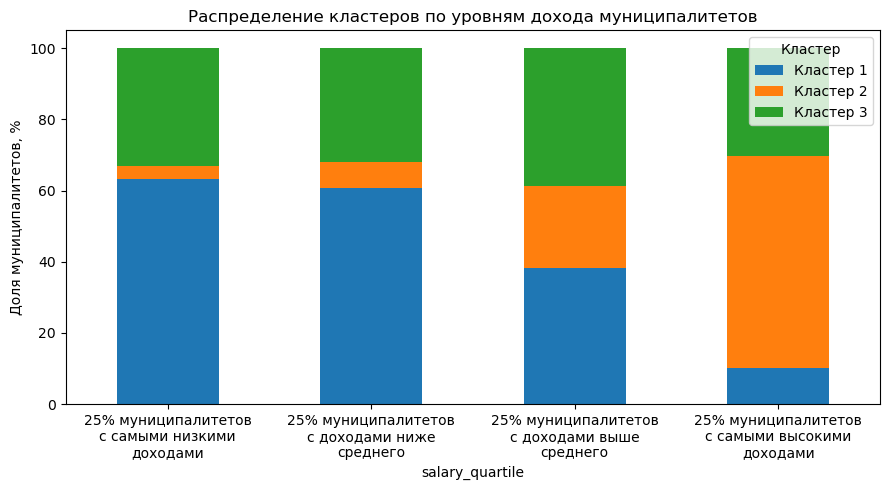

In [143]:
# --- 1. Кросс-таблица кластеров и квартилей дохода ---
cross = pd.crosstab(
    df_with_clusters['salary_quartile'], 
    df_with_clusters['cluster'], 
    normalize='index'
) * 100

# --- 1.1. Сдвигаем обозначения кластеров с 0,1,2 → 1,2,3 ---
cross.columns = [f'Кластер {i+1}' for i in cross.columns]

# --- 2. Переименовываем категории квартилей с переносами строк ---
quartile_labels = {
    'Q1': '25% муниципалитетов\nс самыми низкими\nдоходами',
    'Q2': '25% муниципалитетов\nс доходами ниже\nсреднего',
    'Q3': '25% муниципалитетов\nс доходами выше\nсреднего',
    'Q4': '25% муниципалитетов\nс самыми высокими\nдоходами'
}
cross = cross.rename(index=quartile_labels)

# --- 3. Визуализация ---
cross.plot(kind='bar', stacked=True, figsize=(9,5))
plt.title('Распределение кластеров по уровням дохода муниципалитетов')
plt.ylabel('Доля муниципалитетов, %')
plt.xticks(rotation=0, ha='center')  # без наклона, чтобы переносы работали
plt.legend(title='Кластер')
plt.tight_layout()
plt.show()



## Посмотрим на муниципалитеты с бедным мышлением и богатым.

In [144]:
# Создаем новую колонку с дефолтным значением 0
df_with_clusters['mindset_group'] = 0

# Отмечаем богатые муниципалитеты с "бедным мышлением"
df_with_clusters.loc[
    (df_with_clusters['salary_quartile'] == 'Q4') & (df_with_clusters['cluster'] == 0),
    'mindset_group'
] = 'rich_poormind'

# Отмечаем бедные муниципалитеты с "богатым мышлением"
df_with_clusters.loc[
    (df_with_clusters['salary_quartile'] == 'Q1') & (df_with_clusters['cluster'] == 1),
    'mindset_group'
] = 'poor_richmind'

# Проверим результат
df_with_clusters['mindset_group'].value_counts()



C:\Users\User\AppData\Local\Temp\ipykernel_19208\3082386033.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'rich_poormind' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_with_clusters.loc[


mindset_group
0                292596
rich_poormind      7734
poor_richmind      2796
Name: count, dtype: int64

In [145]:
df_with_clusters[df_with_clusters['mindset_group'] == 'rich_poormind'] \
    .groupby('region_name_x')['territory_id'] \
    .agg(['count', 'nunique']) \
    .rename(columns={'count': 'total_rows', 'nunique': 'unique_territories'}) \
    .sort_values('unique_territories', ascending=False)




,total_rows,unique_territories
region_name_x,,
Республика Карелия,864,6
Владимирская область,432,3
Смоленская область,432,3
Ивановская область,432,3
Тверская область,432,3
Свердловская область,432,3
Тульская область,330,3
Иркутская область,288,2
Нижегородская область,288,2


In [146]:
df_with_clusters[df_with_clusters['mindset_group'] == 'poor_richmind'] \
    .groupby('region_name_x')['territory_id'] \
    .agg(['count', 'nunique']) \
    .rename(columns={'count': 'total_rows', 'nunique': 'unique_territories'}) \
    .sort_values('unique_territories', ascending=False)

,total_rows,unique_territories
region_name_x,,
Республика Башкортостан,576,4
Республика Тыва,426,4
Иркутская область,288,2
Республика Дагестан,60,2
Республика Северная Осетия — Алания,288,2
Чувашская Республика,288,2
Республика Калмыкия,186,2
Астраханская область,144,1
Карачаево-Черкесская Республика,144,1


## Посмотрим, как новые группы соотносятся со средними значениями датасета.

In [147]:
# --- 1. Копируем данные ---
df_analysis = df_with_clusters.copy()

# --- 2. Список показателей для сравнения ---
cols_to_compare = [
    'salary_real', 'consumption_real', 
    'market_access', 'total_population', 'urban_population_pct',
    'migration_index_Женщины_total', 'migration_index_Мужчины_total',
    'roads_defective_percent', 'eco_spending_per_1000', 'building_permits_per_1000'
]

# --- 3. Считаем средние показатели по выбранным группам ---
group_means = (
    df_analysis[df_analysis['mindset_group'].isin(['poor_richmind', 'rich_poormind'])]
    .groupby('mindset_group')[cols_to_compare]
    .mean()
    .round(2)
)

# --- 4. Добавляем строку со средними по всем муниципалитетам ---
overall_mean = df_analysis[cols_to_compare].mean().rename('Среднее по всем муниципалитетам').round(2)
group_means = pd.concat([group_means, overall_mean.to_frame().T])

# --- 5. Считаем отклонение групп от среднего (в %) ---
deviation = ((group_means - overall_mean) / overall_mean * 100).round(1)
deviation = deviation.loc[['poor_richmind', 'rich_poormind']]

# --- 6. Переводим подписи групп и показателей ---
rename_groups = {
    'poor_richmind': 'Бедные муниципалитеты с мышлением богатых',
    'rich_poormind': 'Богатые муниципалитеты с мышлением бедных',
}

rename_columns = {
    'salary_real': 'Реальный доход',
    'consumption_real': 'Реальное потребление',
    'market_access': 'Доступность рынка',
    'total_population': 'Население, чел.',
    'urban_population_pct': 'Доля городского населения, %',
    'migration_index_Женщины_total': 'Миграционный индекс (женщины)',
    'migration_index_Мужчины_total': 'Миграционный индекс (мужчины)',
    'roads_defective_percent': 'Доля дефектных дорог, %',
    'eco_spending_per_1000': 'Экорсходы на 1000 жителей',
    'building_permits_per_1000': 'Разрешения на строительство на 1000 жителей'
}

group_means = group_means.rename(index=rename_groups, columns=rename_columns)
deviation = deviation.rename(index=rename_groups, columns=rename_columns)

# --- 7. Выводим результаты ---
print("=== Средние значения по группам ===")
display(group_means)

print("\n=== Отклонение от среднего (в %) ===")
display(deviation)


=== Средние значения по группам ===


,Реальный доход,Реальное потребление,Доступность рынка,"Население, чел.","Доля городского населения, %",Миграционный индекс (женщины),Миграционный индекс (мужчины),"Доля дефектных дорог, %",Экорсходы на 1000 жителей,Разрешения на строительство на 1000 жителей
Бедные муниципалитеты с мышлением богатых,45957.77,7166.61,300.20,95378.55,25.43,-0.45,-0.14,53.70,3176.14,0.60
Богатые муниципалитеты с мышлением бедных,83140.80,8406.02,319.77,27140.14,65.95,-0.11,-0.02,43.07,20598.02,0.66
Среднее по всем муниципалитетам,64545.51,7720.41,325.34,55629.16,50.04,-0.13,-0.06,48.50,8195.61,0.52



=== Отклонение от среднего (в %) ===


,Реальный доход,Реальное потребление,Доступность рынка,"Население, чел.","Доля городского населения, %",Миграционный индекс (женщины),Миграционный индекс (мужчины),"Доля дефектных дорог, %",Экорсходы на 1000 жителей,Разрешения на строительство на 1000 жителей
Бедные муниципалитеты с мышлением богатых,-28.8,-7.2,-7.7,71.5,-49.2,246.2,133.3,10.7,-61.2,15.4
Богатые муниципалитеты с мышлением бедных,28.8,8.9,-1.7,-51.2,31.8,-15.4,-66.7,-11.2,151.3,26.9


## Посмотрим на муниципалитеты с бедным и богатым мышлением.

In [148]:
# --- 1. Список для poor_richmind ---
poor_richmind_list = df_with_clusters[df_with_clusters['mindset_group'] == 'poor_richmind'] \
    [['municipal_district_name', 'region_name_x']].drop_duplicates().values.tolist()

# --- 2. Список для rich_poormind ---
rich_poormind_list = df_with_clusters[df_with_clusters['mindset_group'] == 'rich_poormind'] \
    [['municipal_district_name', 'region_name_x']].drop_duplicates().values.tolist()

# --- 3. Вывод списков полностью ---
print("=== Poor_richmind ===")
for item in poor_richmind_list:
    print(item)

print("\n=== Rich_poormind ===")
for item in rich_poormind_list:
    print(item)


=== Poor_richmind ===
['Баймакский муниципальный район', 'Республика Башкортостан']
['Бирский муниципальный район', 'Республика Башкортостан']
['Миякинский муниципальный район', 'Республика Башкортостан']
['Стерлибашевский муниципальный район', 'Республика Башкортостан']
['городской округ город Дагестанские Огни', 'Республика Дагестан']
['Новолакский муниципальный район', 'Республика Дагестан']
['Кетченеровский муниципальный район', 'Республика Калмыкия']
['Малодербетовский муниципальный район', 'Республика Калмыкия']
['Ногайский муниципальный район', 'Карачаево-Черкесская Республика']
['городской округ Саранск', 'Республика Мордовия']
['Алагирский муниципальный район', 'Республика Северная Осетия — Алания']
['Дигорский муниципальный район', 'Республика Северная Осетия — Алания']
['Барун-Хемчикский муниципальный район', 'Республика Тыва']
['Сут-Хольский муниципальный район', 'Республика Тыва']
['Улуг-Хемский муниципальный район', 'Республика Тыва']
['Чаа-Хольский муниципальный район', 

ПОсмотрим внимательнее на муниципалитеты из Москвы.

In [149]:
df_with_clusters[
    (df_with_clusters['municipal_district_name'].isin([
        'внутригородская территория города федерального значения поселение Кокошкино',
        'внутригородская территория города федерального значения поселение Роговское'
    ])) 
    & (df_with_clusters['region_name_x'] == 'Москва')
].groupby(['municipal_district_name', 'region_name_x']).mean(numeric_only=True).round(2)

,,territory_id,consumption,oktmo,salary,spending_percentage,year,market_access,total_population,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,eco_spending_thousands,roads_defective_percent,building_permits,index_purchasing_power,salary_real,consumption_real,salary_real_log,category_percentage,eco_spending_per_1000,building_permits_per_1000,cluster
municipal_district_name,region_name_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
внутригородская территория города федерального значения поселение Кокошкино,Москва,2595.0,9789.76,45947000.0,166837.6,5.87,2023.5,525.4,21787.0,0.0,18172.0,100.0,1.14,1.01,1.28,0.12,1.78,0.40,1.18,-0.03,0.83,0.70,NaN,NaN,9.0,149.20,111989.90,6571.11,11.62,28.76,NaN,0.41,0.0
внутригородская территория города федерального значения поселение Роговское,Москва,2603.0,10226.98,45956000.0,157584.4,6.82,2023.7,468.5,6625.0,0.0,5785.0,100.0,9.81,3.90,4.64,1.18,8.24,4.29,2.47,0.94,4.34,3.75,NaN,NaN,NaN,148.48,106427.62,6895.30,11.54,29.28,NaN,NaN,0.0


In [150]:
# Добавляем возрастную группу к pop_aggregated
pop_aggregated['age_group'] = pop_aggregated['age'].apply(age_group)

# Фильтруем нужные муниципалитеты и группируем по age_group и полу
pop_by_age_gender = (
    pop_aggregated[pop_aggregated['territory_id'].isin([2595, 2603])]
    .groupby(['territory_id', 'gender', 'age_group'], as_index=False)
    .agg({'population_value': 'sum'})
)

pop_by_age_gender



,territory_id,gender,age_group,population_value
0,2595,Женщины,0-19,1573.0
1,2595,Женщины,20-40,3551.0
2,2595,Женщины,41-64,2582.0
3,2595,Женщины,65+,3223.0
4,2595,Мужчины,0-19,2084.0
5,2595,Мужчины,20-40,4443.0
6,2595,Мужчины,41-64,2717.0
7,2595,Мужчины,65+,2986.0
8,2603,Женщины,0-19,693.0
9,2603,Женщины,20-40,898.0


In [151]:
df_with_clusters[
    (df_with_clusters['municipal_district_name'].isin([
        'внутригородская территория города федерального значения поселение Кокошкино',
        'внутригородская территория города федерального значения поселение Роговское'
    ])) 
    & (df_with_clusters['region_name_x'] == 'Москва')
].groupby(['municipal_district_name', 'region_name_x']).mean(numeric_only=True).round(2)

,,territory_id,consumption,oktmo,salary,spending_percentage,year,market_access,total_population,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,eco_spending_thousands,roads_defective_percent,building_permits,index_purchasing_power,salary_real,consumption_real,salary_real_log,category_percentage,eco_spending_per_1000,building_permits_per_1000,cluster
municipal_district_name,region_name_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
внутригородская территория города федерального значения поселение Кокошкино,Москва,2595.0,9789.76,45947000.0,166837.6,5.87,2023.5,525.4,21787.0,0.0,18172.0,100.0,1.14,1.01,1.28,0.12,1.78,0.40,1.18,-0.03,0.83,0.70,NaN,NaN,9.0,149.20,111989.90,6571.11,11.62,28.76,NaN,0.41,0.0
внутригородская территория города федерального значения поселение Роговское,Москва,2603.0,10226.98,45956000.0,157584.4,6.82,2023.7,468.5,6625.0,0.0,5785.0,100.0,9.81,3.90,4.64,1.18,8.24,4.29,2.47,0.94,4.34,3.75,NaN,NaN,NaN,148.48,106427.62,6895.30,11.54,29.28,NaN,NaN,0.0


In [152]:
# --- 1. Список колонок для исключения ---
exclude_cols = [
    'territory_id', 'oktmo', 'year', 'region_name_x',
    'index_purchasing_power', 'salary_real_log',
    'category_percentage', 'cluster', 'spending_percentage',
    'consumption', 'salary', 'rural_population', 'urban_population',
    'eco_spending_thousands', 'roads_defective_percent',
    'eco_spending_per_1000', 'building_permits_per_1000',
    'urban_population_pct'
]

# --- 2. Выбираем числовые колонки ---
numeric_cols = [
    c for c in df_with_clusters.select_dtypes(include='number').columns
    if c not in exclude_cols
]

# --- 3. Средние по всем муниципалитетам (генеральная совокупность) ---
overall_means = df_with_clusters[numeric_cols].mean()

# --- 4. Средние по выбранным муниципалитетам ---
subset_means = (
    df_with_clusters[
        (df_with_clusters['territory_id'].isin([2595, 2603]))
    ]
    .groupby(['territory_id', 'municipal_district_name'])
    .mean(numeric_only=True)
)

print("Найдено записей:", len(subset_means))

# --- 5. Создаем словарь для русских названий показателей ---
russian_names = {
    'market_access': 'Доступность рынков',
    'total_population': 'Общая численность населения',
    'migration_index_Женщины_0_19': 'Миграционный индекс женщины 0-19',
    'migration_index_Женщины_20_40': 'Миграционный индекс женщины 20-40', 
    'migration_index_Женщины_41_64': 'Миграционный индекс женщины 41-64',
    'migration_index_Женщины_65plus': 'Миграционный индекс женщины 65+',
    'migration_index_Мужчины_0_19': 'Миграционный индекс мужчины 0-19',
    'migration_index_Мужчины_20_40': 'Миграционный индекс мужчины 20-40',
    'migration_index_Мужчины_41_64': 'Миграционный индекс мужчины 41-64',
    'migration_index_Мужчины_65plus': 'Миграционный индекс мужчины 65+',
    'migration_index_Женщины_total': 'Миграционный индекс женщины всего',
    'migration_index_Мужчины_total': 'Миграционный индекс мужчины всего',
    'building_permits': 'Разрешения на строительство',
    'salary_real': 'Реальная зарплата',
    'consumption_real': 'Реальное потребление'
}

# --- 6. Создаем перевернутую таблицу ---
result_data = []

# Собираем данные для каждого показателя
for col in numeric_cols:
    row_data = {
        'Показатель': russian_names.get(col, col)  # Используем русское название или оригинал
    }
    
    # Добавляем значения для каждого муниципалитета
    for idx in subset_means.index:
        territory_id, municipal_name = idx
        # Используем короткие названия для муниципалитетов
        if territory_id == 2595:
            municipal_short = 'Кокошкино'
        elif territory_id == 2603:
            municipal_short = 'Роговское'
        else:
            municipal_short = municipal_name
            
        subset_val = subset_means.loc[idx, col]
        row_data[municipal_short] = round(subset_val, 1)
    
    # Добавляем среднее по генеральной совокупности
    row_data['Среднее по всем муниципалитетам'] = round(overall_means[col], 1)
    
    result_data.append(row_data)

# Создаем основной DataFrame
result_table = pd.DataFrame(result_data)

# --- 7. Вывод таблицы ---
print("\n" + "=" * 80)
print("СРАВНЕНИЕ ПОКАЗАТЕЛЕЙ: МУНИЦИПАЛИТЕТЫ vs ГЕНЕРАЛЬНАЯ СОВОКУПНОСТЬ")
print("=" * 80)
print("В таблице представлены:")
print("- Каждая строка: отдельный показатель")
print("- Колонки: значения для Кокошкино, Роговское и среднее по всем муниципалитетам")
print("\nИнтерпретация миграционных индексов:")
print("> 0 = миграционный приток")
print("< 0 = миграционный отток") 
print("= 0 = миграционное сальдо нулевое")
print("=" * 80)

result_table

Найдено записей: 2

СРАВНЕНИЕ ПОКАЗАТЕЛЕЙ: МУНИЦИПАЛИТЕТЫ vs ГЕНЕРАЛЬНАЯ СОВОКУПНОСТЬ
В таблице представлены:
- Каждая строка: отдельный показатель
- Колонки: значения для Кокошкино, Роговское и среднее по всем муниципалитетам

Интерпретация миграционных индексов:
> 0 = миграционный приток
< 0 = миграционный отток
= 0 = миграционное сальдо нулевое


,Показатель,Кокошкино,Роговское,Среднее по всем муниципалитетам
0,Доступность рынков,525.4,468.5,325.3
1,Общая численность населения,21787.0,6625.0,55629.2
2,Миграционный индекс женщины 0-19,1.1,9.8,-0.5
3,Миграционный индекс женщины 20-40,1.0,3.9,-0.2
4,Миграционный индекс женщины 41-64,1.3,4.6,-0.0
5,Миграционный индекс женщины 65+,0.1,1.2,-0.0
6,Миграционный индекс мужчины 0-19,1.8,8.2,-0.4
7,Миграционный индекс мужчины 20-40,0.4,4.3,0.0
8,Миграционный индекс мужчины 41-64,1.2,2.5,0.0
9,Миграционный индекс мужчины 65+,-0.0,0.9,-0.0


## Посмотрим на один из "бедных с богатыми привычками" МО

In [153]:
df_with_clusters[
    (df_with_clusters['municipal_district_name'].isin([
        'Дигорский муниципальный район',
    ])) 
    & (df_with_clusters['region_name_x'] == 'Республика Северная Осетия — Алания')
].groupby(['municipal_district_name', 'region_name_x']).mean(numeric_only=True).round(2)

,,territory_id,consumption,oktmo,salary,spending_percentage,year,market_access,total_population,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,eco_spending_thousands,roads_defective_percent,building_permits,index_purchasing_power,salary_real,consumption_real,salary_real_log,category_percentage,eco_spending_per_1000,building_permits_per_1000,cluster
municipal_district_name,region_name_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Дигорский муниципальный район,Республика Северная Осетия — Алания,348.0,6287.69,90615000.0,34318.55,18.29,2023.5,293.7,18555.0,NaN,NaN,NaN,-0.43,0.7,0.04,0.09,0.22,0.66,0.35,0.12,0.1,0.37,NaN,NaN,NaN,73.55,46697.45,8557.82,10.75,28.29,NaN,NaN,1.0


In [154]:
# --- 1. Список колонок для исключения ---
exclude_cols = [
    'territory_id', 'oktmo', 'year', 'region_name_x',
    'index_purchasing_power', 'salary_real_log',
    'category_percentage', 'cluster', 'spending_percentage',
    'consumption', 'salary', 'rural_population', 'urban_population',
    'eco_spending_thousands', 'roads_defective_percent',
    'eco_spending_per_1000', 'building_permits_per_1000',
    'urban_population_pct', 'building_permits'
]

# --- 2. Выбираем числовые колонки ---
numeric_cols = [
    c for c in df_with_clusters.select_dtypes(include='number').columns
    if c not in exclude_cols
]

# --- 3. Средние по всем муниципалитетам (генеральная совокупность) ---
overall_means = df_with_clusters[numeric_cols].mean()

# --- 4. Средние по выбранным муниципалитетам ---
subset_means = (
    df_with_clusters[
        (df_with_clusters['territory_id'].isin([348]))
    ]
    .groupby(['territory_id', 'municipal_district_name'])
    .mean(numeric_only=True)
)

print("Найдено записей:", len(subset_means))

# --- 5. Создаем словарь для русских названий показателей ---
russian_names = {
    'market_access': 'Доступность рынков',
    'total_population': 'Общая численность населения',
    'urban_population_pct': 'Доля городского населения (%)',
    'migration_index_Женщины_0_19': 'Миграционный индекс женщины 0-19',
    'migration_index_Женщины_20_40': 'Миграционный индекс женщины 20-40', 
    'migration_index_Женщины_41_64': 'Миграционный индекс женщины 41-64',
    'migration_index_Женщины_65plus': 'Миграционный индекс женщины 65+',
    'migration_index_Мужчины_0_19': 'Миграционный индекс мужчины 0-19',
    'migration_index_Мужчины_20_40': 'Миграционный индекс мужчины 20-40',
    'migration_index_Мужчины_41_64': 'Миграционный индекс мужчины 41-64',
    'migration_index_Мужчины_65plus': 'Миграционный индекс мужчины 65+',
    'migration_index_Женщины_total': 'Миграционный индекс женщины всего',
    'migration_index_Мужчины_total': 'Миграционный индекс мужчины всего',
    'salary_real': 'Реальная зарплата',
    'consumption_real': 'Реальное потребление'
}

# --- 6. Создаем перевернутую таблицу ---
result_data = []

# Собираем данные для каждого показателя
for col in numeric_cols:
    row_data = {
        'Показатель': russian_names.get(col, col)
    }
    
    # Добавляем значения для каждого муниципалитета
    for idx in subset_means.index:
        territory_id, municipal_name = idx
        # Используем реальное название муниципалитета из данных
        municipal_short = municipal_name
            
        subset_val = subset_means.loc[idx, col]
        row_data[municipal_short] = round(subset_val, 1)
    
    # Добавляем среднее по генеральной совокупности
    row_data['Среднее по всем муниципалитетам'] = round(overall_means[col], 1)
    
    result_data.append(row_data)

# Создаем основной DataFrame
result_table = pd.DataFrame(result_data)

# --- 7. Вывод таблицы ---
print("\n" + "=" * 80)
print("СРАВНЕНИЕ ПОКАЗАТЕЛЕЙ: МУНИЦИПАЛИТЕТ 348 vs ГЕНЕРАЛЬНАЯ СОВОКУПНОСТЬ")
print("=" * 80)
print("В таблице представлены:")
print("- Каждая строка: отдельный показатель") 
print("- Колонки: значения для муниципалитета 348 и среднее по всем муниципалитетам")
print("\nИнтерпретация миграционных индексов:")
print("> 0 = миграционный приток")
print("< 0 = миграционный отток")
print("= 0 = миграционное сальдо нулевое")
print("=" * 80)

result_table

Найдено записей: 1

СРАВНЕНИЕ ПОКАЗАТЕЛЕЙ: МУНИЦИПАЛИТЕТ 348 vs ГЕНЕРАЛЬНАЯ СОВОКУПНОСТЬ
В таблице представлены:
- Каждая строка: отдельный показатель
- Колонки: значения для муниципалитета 348 и среднее по всем муниципалитетам

Интерпретация миграционных индексов:
> 0 = миграционный приток
< 0 = миграционный отток
= 0 = миграционное сальдо нулевое


,Показатель,Дигорский муниципальный район,Среднее по всем муниципалитетам
0,Доступность рынков,293.7,325.3
1,Общая численность населения,18555.0,55629.2
2,Миграционный индекс женщины 0-19,-0.4,-0.5
3,Миграционный индекс женщины 20-40,0.7,-0.2
4,Миграционный индекс женщины 41-64,0.0,-0.0
5,Миграционный индекс женщины 65+,0.1,-0.0
6,Миграционный индекс мужчины 0-19,0.2,-0.4
7,Миграционный индекс мужчины 20-40,0.7,0.0
8,Миграционный индекс мужчины 41-64,0.4,0.0
9,Миграционный индекс мужчины 65+,0.1,-0.0


Проверим отдельно, что покупательское поведение этих муниципалитетов действительно отличается.ь

In [155]:
# --- 1. Копируем данные ---
df_analysis = df_with_clusters.copy()

# --- 2. Оставляем только нужные категории ---
df_analysis = df_analysis[df_analysis['category'] != 'Все категории'].copy()

# --- 3. Считаем среднюю долю категории по каждому муниципалитету ---
df_mean_cat = (
    df_analysis.groupby(['territory_id', 'category'])['category_percentage']
    .mean()
    .reset_index()
)

# --- 4. Добавляем к каждому муниципалитету метку mindset_group ---
df_mean_cat = df_mean_cat.merge(
    df_with_clusters[['territory_id', 'mindset_group']],
    on='territory_id',
    how='left'
)

# --- 5. Фильтруем только нужные группы ---
df_mean_cat = df_mean_cat[df_mean_cat['mindset_group'].isin(['poor_richmind', 'rich_poormind'])]

# --- 6. Считаем средние значения по категориям для двух групп ---
group_means_cat = (
    df_mean_cat.groupby(['mindset_group', 'category'])['category_percentage']
    .mean()
    .unstack('mindset_group')
    .round(2)
)

# --- 7. Добавляем строку со средними по всем муниципалитетам ---
overall_mean_cat = df_mean_cat.groupby('category')['category_percentage'].mean().rename('overall_mean').round(2)
group_means_cat = pd.concat([group_means_cat, overall_mean_cat], axis=1)

# --- 8. Считаем отклонение групп от среднего (в %) ---
deviation_cat = ((group_means_cat[['poor_richmind', 'rich_poormind']] - group_means_cat['overall_mean'].values.reshape(-1, 1)) 
                 / group_means_cat['overall_mean'].values.reshape(-1, 1) * 100).round(1)

# --- 9. Выводим результаты ---
print("=== Средние значения по категориям для групп mindset_group ===")
display(group_means_cat)

print("\n=== Отклонение от среднего (в %) для poor_richmind и rich_poormind ===")
display(deviation_cat)


=== Средние значения по категориям для групп mindset_group ===


,poor_richmind,rich_poormind,overall_mean
category,,,
Здоровье,5.35,4.52,4.74
Маркетплейсы,14.43,16.85,16.20
Общественное питание,4.40,2.62,3.09
Продовольствие,37.36,44.57,42.65
Транспорт,8.58,4.45,5.55



=== Отклонение от среднего (в %) для poor_richmind и rich_poormind ===


,poor_richmind,rich_poormind
category,,
Здоровье,12.9,-4.6
Маркетплейсы,-10.9,4.0
Общественное питание,42.4,-15.2
Продовольствие,-12.4,4.5
Транспорт,54.6,-19.8


## Построим модель, как показатели муниципалитета связаны с процентом безналичных платежей.

In [156]:
# --- 1. Берём строки только за 2024 год и категорию "Все категории" ---
df_2024_spend = df[
    (df['category'] == 'Все категории') &
    (df['year'] == 2024)
].copy()

# --- 2. Считаем медиану доли безналичных трат по каждому муниципалитету ---
df_spend_median_2024 = (
    df_2024_spend
    .groupby('territory_id')['spending_percentage']
    .median()
    .reset_index()
    .rename(columns={'spending_percentage': 'spending_median_allcat_2024'})
)

print("Медианные значения безналичных трат (2024 год) рассчитаны")
display(df_spend_median_2024.head())

# --- 3. Объединяем с основным датасетом df_2024_mean ---
df_model = df_2024_mean.merge(df_spend_median_2024, on='territory_id', how='left')

print("Финальный датасет для модели готов")
print("Размер:", df_model.shape)
display(df_model.head())

# --- 4. Проверим пропуски ---
print("\nКоличество пропусков в новом показателе:")
print(df_model['spending_median_allcat_2024'].isna().sum())



Медианные значения безналичных трат (2024 год) рассчитаны


,territory_id,spending_median_allcat_2024
0,1,50.35
1,2,45.40
2,3,41.00
3,4,45.90
4,5,46.25


Финальный датасет для модели готов
Размер: (2127, 34)


,territory_id,municipal_district_name,region_name_x,consumption,oktmo,salary,spending_percentage,year,market_access,total_population,rural_population,urban_population,urban_population_pct,migration_index_Женщины_0_19,migration_index_Женщины_20_40,migration_index_Женщины_41_64,migration_index_Женщины_65plus,migration_index_Мужчины_0_19,migration_index_Мужчины_20_40,migration_index_Мужчины_41_64,migration_index_Мужчины_65plus,migration_index_Женщины_total,migration_index_Мужчины_total,eco_spending_thousands,roads_defective_percent,building_permits,index_purchasing_power,salary_real,consumption_real,salary_real_log,category_percentage,eco_spending_per_1000,building_permits_per_1000,spending_median_allcat_2024
0,1,городской округ город Майкоп,Республика Адыгея,8332.694444,79701000.0,57440.5,14.508333,2024.0,309.6,161898.0,21702.0,120831.0,84.77,-0.90,-1.66,-0.69,-0.39,-1.16,-1.78,-0.91,-0.35,-0.88,-1.11,998925.0,35.1,53.0,84.9,67656.7,9814.719444,11.122202,28.515278,6170.09,0.33,50.35
1,2,городской округ город Адыгейск,Республика Адыгея,6242.750000,79703000.0,47407.2,13.172222,2024.0,322.8,15661.0,2233.0,12091.0,84.41,-1.58,0.00,0.40,0.35,0.67,1.29,0.48,-0.25,-0.09,0.67,45777.0,17.0,17.0,84.9,55838.9,7353.059722,10.930226,28.866667,2922.99,1.09,45.40
2,3,Гиагинский муниципальный район,Республика Адыгея,6474.472222,79605000.0,54547.7,11.866667,2024.0,315.2,31872.0,28452.0,0.0,0.00,0.50,0.32,-0.06,0.05,0.10,0.74,0.46,0.03,0.18,0.36,31563.0,7.1,20.0,84.9,64249.4,7625.997222,11.070528,29.141667,990.30,0.63,41.00
3,4,Кошехабльский муниципальный район,Республика Адыгея,6882.541667,79615000.0,51262.1,13.422222,2024.0,315.5,30319.0,27181.0,0.0,0.00,1.67,1.17,0.12,0.18,1.86,0.79,0.26,0.22,0.73,0.80,27752.0,1.6,4.0,84.9,60379.4,8106.650000,11.008403,28.734722,915.33,0.13,45.90
4,5,Красногвардейский муниципальный район,Республика Адыгея,6461.111111,79618000.0,48849.1,13.226389,2024.0,320.2,32095.0,29069.0,0.0,0.00,1.32,0.54,0.20,-0.19,1.10,0.46,0.87,-0.52,0.39,0.52,9249.0,12.5,11.0,84.9,57537.2,7610.263889,10.960187,28.920833,288.18,0.34,46.25



Количество пропусков в новом показателе:
0


In [157]:
df_model = df_model.dropna()

In [158]:
# --- 1. Берём датасет с рассчитанной медианой ---
df_model = df_model.dropna(subset=['spending_median_allcat_2024']).copy()

# --- 2. Определяем зависимую и независимые переменные ---
y = df_model['spending_median_allcat_2024']

X = df_model[[
    'salary_real',
    'market_access',
    'total_population',
    'urban_population_pct',
    'migration_index_Мужчины_total',
    'roads_defective_percent',
    'eco_spending_per_1000',
    'building_permits_per_1000'
]]


=== Корреляционная матрица признаков ===


,salary_real,market_access,total_population,urban_population_pct,migration_index_Мужчины_total,roads_defective_percent,eco_spending_per_1000,building_permits_per_1000
salary_real,1.00,-0.12,0.23,0.28,0.12,-0.20,0.33,0.33
market_access,-0.12,1.00,0.13,-0.01,0.20,-0.06,-0.14,-0.11
total_population,0.23,0.13,1.00,0.33,0.10,-0.17,0.01,-0.09
urban_population_pct,0.28,-0.01,0.33,1.00,0.05,-0.17,0.05,-0.18
migration_index_Мужчины_total,0.12,0.20,0.10,0.05,1.00,-0.12,0.23,0.14
roads_defective_percent,-0.20,-0.06,-0.17,-0.17,-0.12,1.00,-0.10,0.03
eco_spending_per_1000,0.33,-0.14,0.01,0.05,0.23,-0.10,1.00,0.32
building_permits_per_1000,0.33,-0.11,-0.09,-0.18,0.14,0.03,0.32,1.00


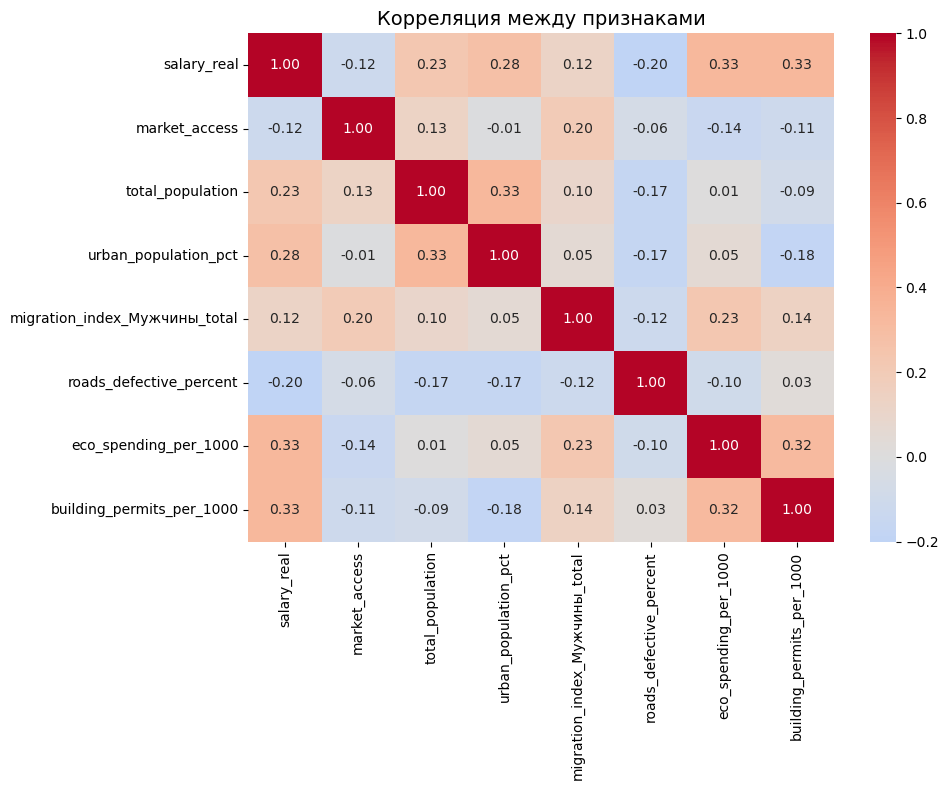

In [159]:
# --- 1. Считаем корреляционную матрицу ---
corr_matrix = X.corr().round(2)

# --- 2. Выводим матрицу ---
print("=== Корреляционная матрица признаков ===")
display(corr_matrix)

# --- 3. Строим тепловую карту ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Корреляция между признаками", fontsize=14)
plt.tight_layout()
plt.show()


In [160]:
# # --- 3. Добавляем константу ---
# X = sm.add_constant(X)

# # --- 4. Строим модель OLS ---
# model = sm.OLS(y, X).fit()

# # --- 5. Выводим результаты ---
# print(model.summary())


# --- 3. Стандартизация (с сохранением индекса) ---
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index  # сохраняем индекс, чтобы совпал с y
)

# --- 4. Добавляем константу и строим модель ---
X_scaled = sm.add_constant(X_scaled)
model_std = sm.OLS(y, X_scaled).fit()

# --- 5. Выводим результаты ---
print(model_std.summary())




                                 OLS Regression Results                                
Dep. Variable:     spending_median_allcat_2024   R-squared:                       0.434
Model:                                     OLS   Adj. R-squared:                  0.430
Method:                          Least Squares   F-statistic:                     102.4
Date:                         Wed, 12 Nov 2025   Prob (F-statistic):          1.68e-126
Time:                                 15:27:43   Log-Likelihood:                -3439.3
No. Observations:                         1078   AIC:                             6897.
Df Residuals:                             1069   BIC:                             6941.
Df Model:                                    8                                         
Covariance Type:                     nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

Построенная модель демонстрирует, что включённые социально-экономические характеристики муниципалитетов объясняют около 43% вариации медианной доли безналичных платежей от начисленной заработной платы (R² = 0.434). Так как все независимые переменные были стандартизированы, значения коэффициентов отражают силу и направление влияния каждого фактора в стандартных отклонениях, что позволяет сравнивать их между собой по значимости воздействия.

Наибольшее отрицательное влияние оказывает реальный уровень зарплаты (salary_real): увеличение этого показателя на одно стандартное отклонение связано со снижением доли безналичных платежей на 4.41 стандартного отклонения. Это означает, что в более обеспеченных муниципалитетах безналичные операции занимают относительно меньшую часть от зарплаты, возможно, из-за большего использования наличных или иных каналов расходов.

Напротив, доступность рынков (market_access), общая численность населения (total_population), доля городского населения (urban_population_pct), миграционный индекс мужчин (migration_index_Мужчины_total) и число разрешений на строительство (building_permits_per_1000) оказывают положительное влияние. Их рост сопровождается увеличением доли безналичных платежей. Особенно сильный эффект наблюдается у показателя урбанизации: более высокая доля городского населения связана с активным использованием безналичных форм расчётов, что отражает влияние инфраструктурных и технологических факторов. Положительные коэффициенты при рыночной доступности и численности населения указывают на то, что муниципалитеты с лучшей транспортной связанностью и более крупными рынками быстрее переходят к безналичным платежам. Приток мужского населения также ассоциирован с ростом безналичных платежей, что, вероятно, связано с демографическим оживлением и экономической активностью территорий.

Переменная eco_spending_per_1000, отражающая расходы на экологию, имеет отрицательный и значимый коэффициент (–1.43), что может свидетельствовать о том, что муниципалитеты, направляющие больше средств на экологические программы, как правило, характеризуются менее развитой финансовой или цифровой инфраструктурой. Влияние доли дорог в ненормативном состоянии (roads_defective_percent) статистически незначимо, следовательно, качество дорожной сети не оказывает заметного эффекта на распространённость безналичных платежей.

В целом, модель показывает, что более урбанизированные, густонаселённые и экономически связанные муниципалитеты характеризуются более высокой долей безналичных операций, тогда как более высокий уровень доходов и направленность расходов на экологию ассоциируются с их относительным снижением.

In [161]:
df_with_clusters['cluster'].unique()

array([1, 0, 2], dtype=int32)

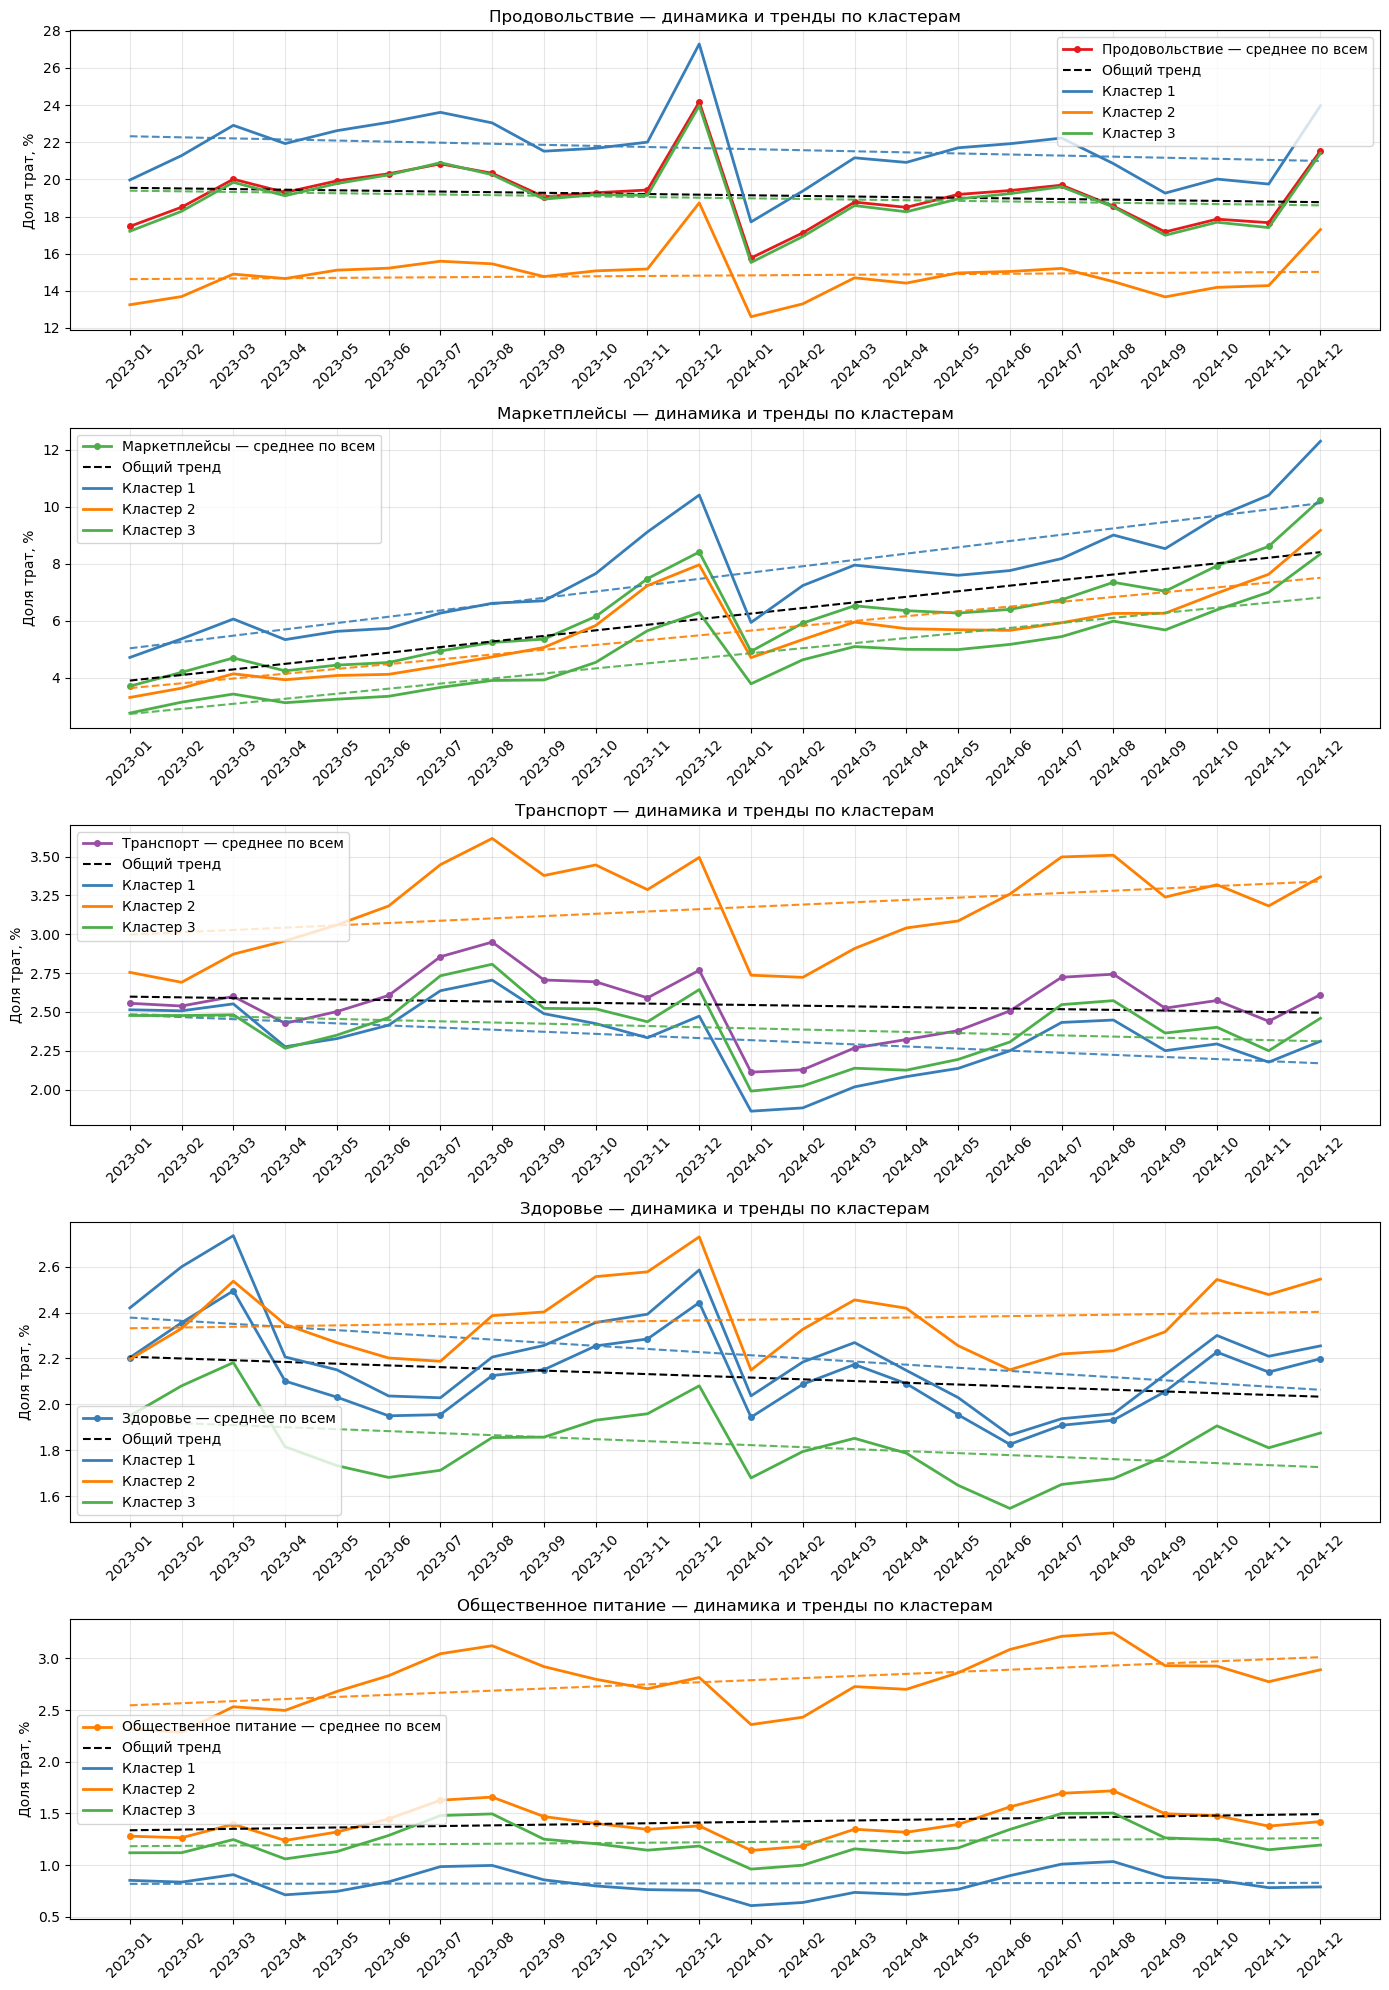

In [162]:
# --- 1. Фильтруем данные ---
category_data = df_with_clusters[
    (df_with_clusters['category'] != 'Все категории') &
    (df_with_clusters['spending_percentage'].notnull())
].copy()

# --- 2. Преобразуем spending_percentage в числовой формат ---
category_data['spending_percentage'] = category_data['spending_percentage'].astype(float)

# --- 3. Меняем нумерацию кластеров с 0,1,2 на 1,2,3 ---
category_data['cluster'] = category_data['cluster'] + 1

# --- 4. Средние значения по дате, категории и кластеру ---
time_series_clustered = (
    category_data
    .groupby(['date', 'category', 'cluster'])['spending_percentage']
    .mean()
    .reset_index()
    .sort_values('date')
)

# --- 5. Средние значения по дате и категории (без кластеров) ---
time_series_category = (
    category_data
    .groupby(['date', 'category'])['spending_percentage']
    .mean()
    .reset_index()
    .sort_values('date')
)

# --- 6. Определяем топ-5 категорий ---
category_means = (
    category_data
    .groupby('category')['spending_percentage']
    .mean()
    .sort_values(ascending=False)
)
top_categories = category_means.head(5).index

# --- 7. Цвета ---
category_colors = {
    'Продовольствие': '#E41A1C',   # красный
    'Здоровье': '#377EB8',         # синий
    'Маркетплейсы': '#4DAF4A',     # зелёный
    'Общественное питание': '#FF7F00',  # оранжевый
    'Транспорт': '#984EA3'         # фиолетовый
}

# цвета для кластеров 1, 2, 3 (после преобразования)
cluster_colors = {
    1: '#377EB8',  # синий
    2: '#FF7F00',  # оранжевый
    3: '#4DAF4A'   # зелёный
}

# --- 8. Построение графиков ---
fig, axes = plt.subplots(5, 1, figsize=(14, 20))
axes = axes.flatten()

for i, category in enumerate(top_categories):
    df_cat = time_series_category[time_series_category['category'] == category]
    color = category_colors.get(category, 'gray')

    # общий тренд
    X = np.arange(len(df_cat)).reshape(-1, 1)
    y = df_cat['spending_percentage'].values
    model = LinearRegression().fit(X, y)
    trend_all = model.predict(X)

    axes[i].plot(
        df_cat['date'].astype(str),
        df_cat['spending_percentage'],
        marker='o', linewidth=2, markersize=4,
        color=color, label=f'{category} — среднее по всем'
    )
    axes[i].plot(df_cat['date'].astype(str), trend_all, color='black', linestyle='--', label='Общий тренд')

    # тренды по кластерам (1, 2, 3)
    for cluster_id, clr in cluster_colors.items():
        df_cl = time_series_clustered[
            (time_series_clustered['category'] == category) &
            (time_series_clustered['cluster'] == cluster_id)
        ]
        if df_cl.empty:
            continue

        Xc = np.arange(len(df_cl)).reshape(-1, 1)
        yc = df_cl['spending_percentage'].values
        model_c = LinearRegression().fit(Xc, yc)
        trend_c = model_c.predict(Xc)

        axes[i].plot(
            df_cl['date'].astype(str),
            df_cl['spending_percentage'],
            linewidth=2,
            color=clr,
            label=f'Кластер {cluster_id}'
        )
        axes[i].plot(
            df_cl['date'].astype(str),
            trend_c,
            linestyle='--',
            color=clr,
            alpha=0.9
        )

    axes[i].set_title(f'{category} — динамика и тренды по кластерам', fontsize=12)
    axes[i].set_ylabel('Доля трат, %')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()